Exploratory Analysis Code

Load in all the imports necessary

In [ ]:
pip install 'scanpy[leiden]'

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
import re

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, f1_score, silhouette_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
import scanpy as sc
import anndata as ad

# Read in all the data required!

In [ ]:
with open('/content/GSE81608_series_matrix .txt', 'r') as file:
    lines = file.readlines()

metadata_lines = [line.strip() for line in lines if line.startswith('!')]

for line in metadata_lines:
    print(line)

data = pd.read_csv('/content/GSE81608_human_islets_rpkm.txt', sep='\t', index_col=0)

labels = [0 if i < 651 else 1 for i in range(len(data.columns))]

#transpose the dataframe
data = data.T
data['label'] = labels
data.head()

Output hidden; open in https://colab.research.google.com to view.

#check the formatteing of this data and clean it up!

In [ ]:
print(data.head(50))
print(data.info())
print(data.describe())
print("Missing values per column:\n", data.isnull().sum())

gene.id          1         2    3         9   10   11       12   13        14  \
Sample_1   47.3396    0.0000  0.0    0.0000  0.0  0.0   0.0000  0.0   31.2047   
Sample_2   24.0458    0.0000  0.0    0.0000  0.0  0.0  14.0425  0.0    0.0000   
Sample_3    2.2743    0.0000  0.0    0.0000  0.0  0.0   0.8412  0.0    7.8214   
Sample_4    0.0000    0.0000  0.0    0.0000  0.0  0.0   0.0000  0.0    0.0000   
Sample_5    0.0000    0.0000  0.0  130.9796  0.0  0.0   0.0000  0.0  120.6832   
Sample_6    0.0000    0.0000  0.0    0.0000  0.0  0.0   0.8614  0.0    2.8034   
Sample_7    0.0000    0.0000  0.0    0.0000  0.0  0.0   0.0000  0.0    0.7957   
Sample_8    0.0000    0.2540  0.0    0.0000  0.0  0.0  84.9357  0.0    0.6581   
Sample_9    0.0000    0.0000  0.0    0.0000  0.0  0.0   0.0000  0.0    0.0000   
Sample_10   2.0351    0.0000  0.0   79.5905  0.0  0.0   0.0000  0.0   32.5457   
Sample_11   1.7625    0.0000  0.0    0.0000  0.0  0.0   0.0000  0.0    0.0000   
Sample_12  14.5316    0.0000

Imputate our data by using SimpleImputer, this will grab the nearest neighbor

In [ ]:
impute = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_data = impute.fit_transform(data.drop(columns=['label']))

Create AnnData object

In [ ]:
anndata = ad.AnnData(imputed_data)

Normalize AnnData Object using reccomended package Scanpy

In [ ]:
sc.pp.normalize_total(adata=anndata, target_sum=1e4, exclude_highly_expressed=False)
new_data = anndata.X

Create a preliminary PCA, with 2 components

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(new_data)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['label'] = data['label'].values

pca_df['group'] = pca_df['label'].map({0: 'Control', 1: 'T2D'})

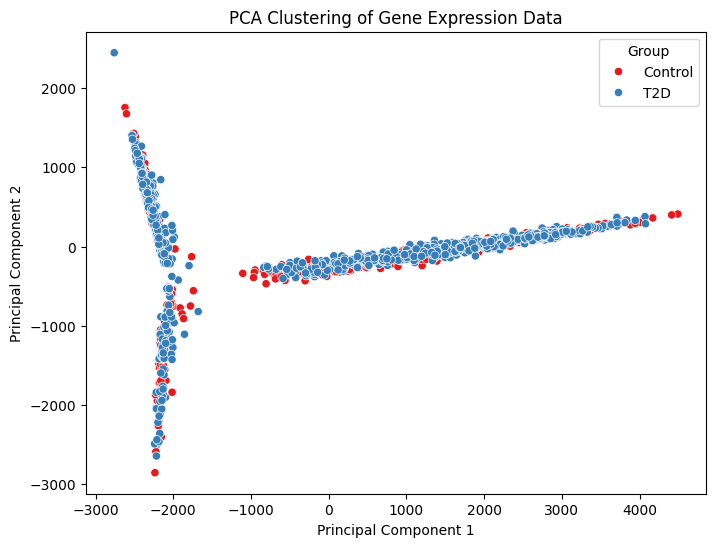

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='group', data=pca_df, palette='Set1')
plt.title('PCA Clustering of Gene Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Group')
plt.show()

file_path = "/content/Basic_PCA_2_component.jpeg"
plt.savefig(file_path, format="jpeg")
plt.close()


In [ ]:
silhouette_avg = silhouette_score(pca_result, data['label'])
print(f"Silhouette Score: {silhouette_avg}")

#not very good!

Silhouette Score: 0.003992489681124279


Let's try this with another PCA function from the Scanpy package as well

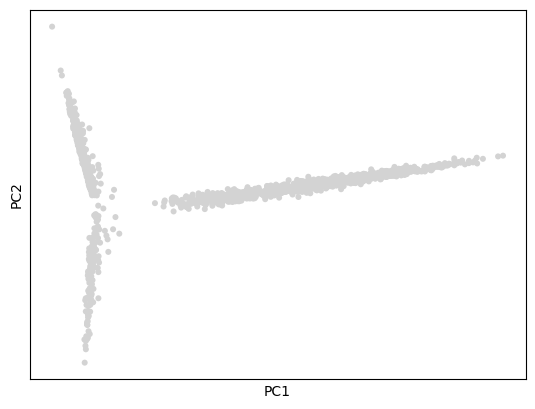

In [ ]:
sc.tl.pca(anndata)
sc.pl.pca(anndata, components=['1,2'])
#similar result

Read in the Metadate to combine with the Gene Expression Data

In [ ]:


metadata_file = "/content/GSE81608_series_matrix .txt"

ages = []
genders = []
cell_subtypes = []

with open(metadata_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line.startswith('!Sample_characteristics_ch1'):
            characteristics = re.findall(r'"([^"]+)"', line)
            if characteristics:
                first_char = characteristics[0]
                if ':' in first_char:
                    attr_name, _ = first_char.split(':', 1)
                    attr_name = attr_name.strip().lower()
                    values = []
                    for ch in characteristics:
                        if ':' in ch:
                            _, val = ch.split(':', 1)
                            values.append(val.strip())
                    if attr_name == 'age':
                        ages = values
                    elif attr_name == 'gender':
                        genders = values
                    elif attr_name == 'cell subtype':
                        cell_subtypes = values
print("Ages:", ages)
print("Genders:", genders)
print("Cell Subtypes:", cell_subtypes)

#check to see if they are the same length! They should be 1600

Ages: ['23', '23', '23', '23', '23', '23', '23', '23', '23', '23', '23', '23', '23', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '32', '23', '23', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '27', '68', '68', '68', '68', '68', '68', '68', '29', '29', '29', '29', '29', '29', '29', '29', '29', '29', '29', '29', '29', '29', '29', '29', '29', '60', '60', '60', '60', '60', '60', '60', '60', '60', '23', '23', '23', '23', '23', '23', '23', '23', '60', '60', '60', '60', '60', '60', '60', '60', '24', '24', '24', '24', '24', '24', '24', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '43', '31', '31', '31', '31', '31', '31', '31', '31', '31', '31', '31', '31', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56', '56

In [ ]:
# add this to our existing data!
data['Age'] = ages
data['Gender'] = genders
data['cell_subtype'] = cell_subtypes

print(data)


gene.id            1        2    3         9   10   11        12      13  \
Sample_1     47.3396   0.0000  0.0    0.0000  0.0  0.0    0.0000  0.0000   
Sample_2     24.0458   0.0000  0.0    0.0000  0.0  0.0   14.0425  0.0000   
Sample_3      2.2743   0.0000  0.0    0.0000  0.0  0.0    0.8412  0.0000   
Sample_4      0.0000   0.0000  0.0    0.0000  0.0  0.0    0.0000  0.0000   
Sample_5      0.0000   0.0000  0.0  130.9796  0.0  0.0    0.0000  0.0000   
...              ...      ...  ...       ...  ...  ...       ...     ...   
Sample_1596   0.0000   0.0000  0.0    0.0000  0.0  0.0  124.9825  0.2714   
Sample_1597   0.5372   0.0000  0.0    0.0000  0.0  0.0    3.5763  0.0000   
Sample_1598  31.1225   0.0000  0.0    0.0000  0.0  0.0    0.0000  0.0000   
Sample_1599   0.0000  47.4664  0.0    0.0000  0.0  0.0    0.0000  0.0000   
Sample_1600   0.5788   0.0000  0.0    0.0000  0.0  0.0    0.0000  0.0000   

gene.id            14   15  ...  101929770  101929771  101930100  102723951  \
Sample_1

Let's look at the distribution of differing characteristics of our data

1st. Variability of genes

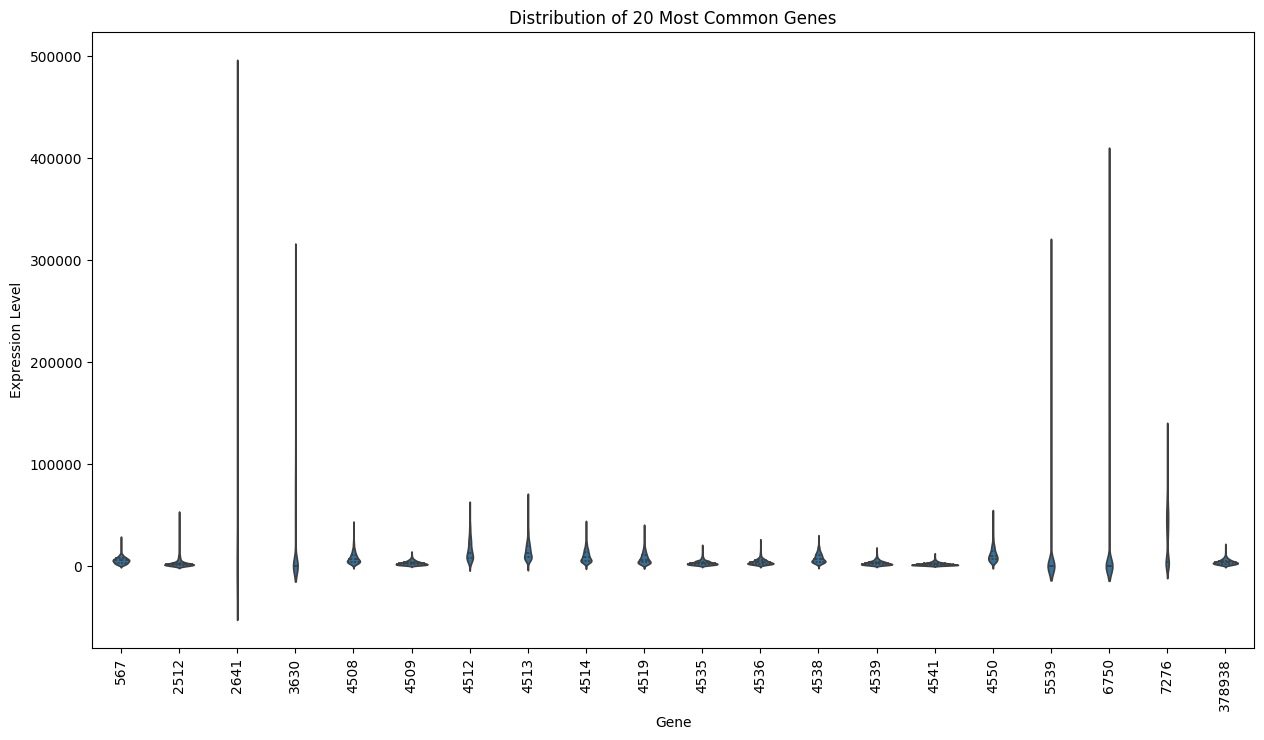

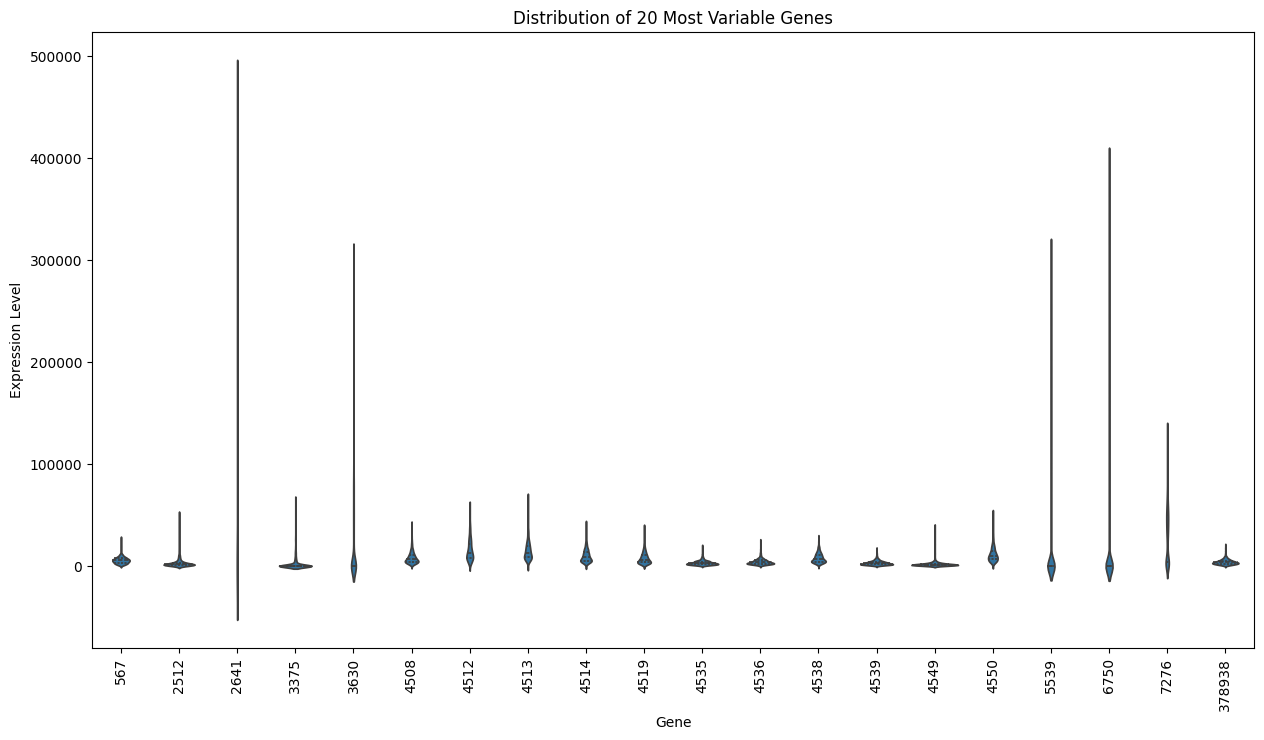

In [ ]:
numeric_cols = data.select_dtypes(include=np.number).columns
data[numeric_cols] = data[numeric_cols].astype(float) # If any are not float/int
most_common_genes = data[numeric_cols].sum(axis=0).nlargest(20).index
most_variable_genes = data[numeric_cols].var(axis=0).nlargest(20).index
df_common = data[most_common_genes].melt(var_name='Gene', value_name='Expression Level')
df_variable = data[most_variable_genes].melt(var_name='Gene', value_name='Expression Level')

plt.figure(figsize=(15, 8))
sns.violinplot(x='Gene', y='Expression Level', data=df_common, inner='quartile')
plt.title('Distribution of 20 Most Common Genes')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15, 8))
sns.violinplot(x='Gene', y='Expression Level', data=df_variable, inner='quartile')
plt.title('Distribution of 20 Most Variable Genes')
plt.xticks(rotation=90)
plt.show()


Interesting

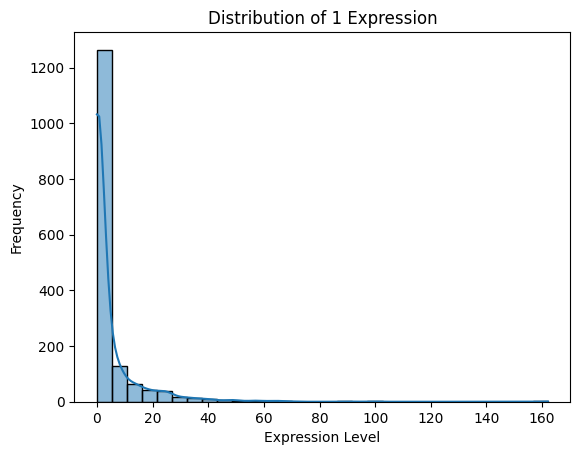

In [ ]:
gene_to_plot = data.columns[0]

sns.histplot(data[gene_to_plot], kde=True, bins=30)
plt.title(f'Distribution of {gene_to_plot} Expression')
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.show()


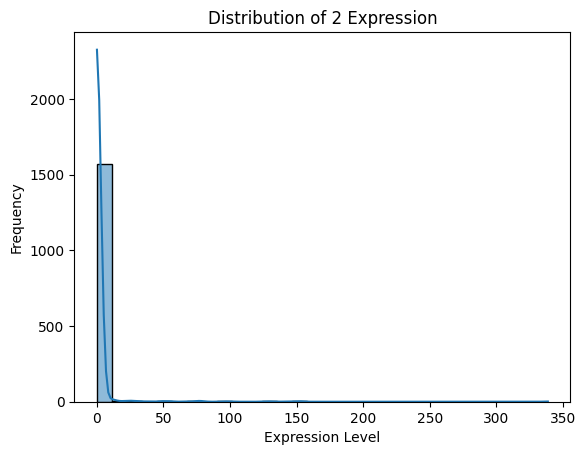

In [ ]:
gene_to_plot = data.columns[1]

sns.histplot(data[gene_to_plot], kde=True, bins=30)
plt.title(f'Distribution of {gene_to_plot} Expression')
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.show()


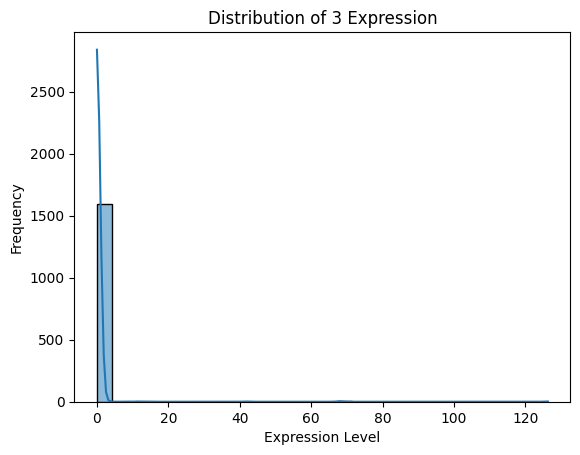

In [ ]:
gene_to_plot = data.columns[2]

sns.histplot(data[gene_to_plot], kde=True, bins=30)
plt.title(f'Distribution of {gene_to_plot} Expression')
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.show()


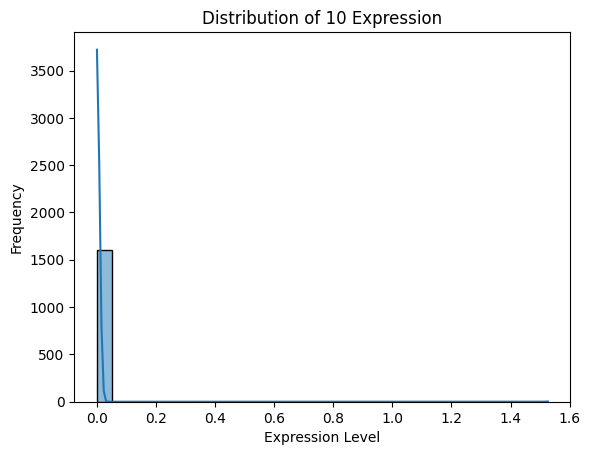

In [ ]:

gene_to_plot = data.columns[4]

sns.histplot(data[gene_to_plot], kde=True, bins=30)
plt.title(f'Distribution of {gene_to_plot} Expression')
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.show()


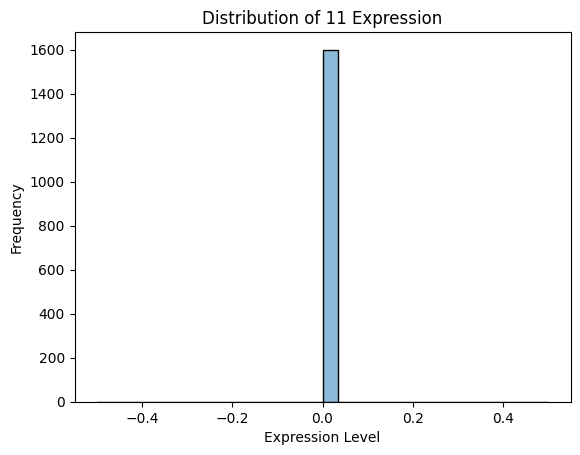

In [ ]:
gene_to_plot = data.columns[5]

sns.histplot(data[gene_to_plot], kde=True, bins=30)
plt.title(f'Distribution of {gene_to_plot} Expression')
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.show()


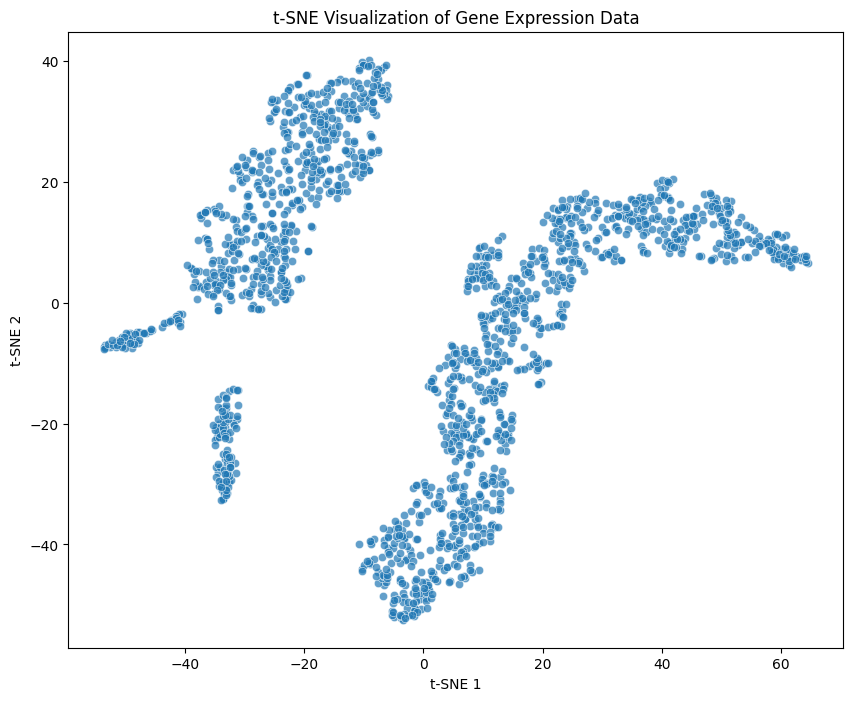

In [ ]:
features = [col for col in data.columns if col not in ['label', 'Age', 'Gender', 'cell_subtype']]
df_features = data[features]

df_features.columns = df_features.columns.astype(str)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(df_features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], alpha=0.7)
plt.title('t-SNE Visualization of Gene Expression Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

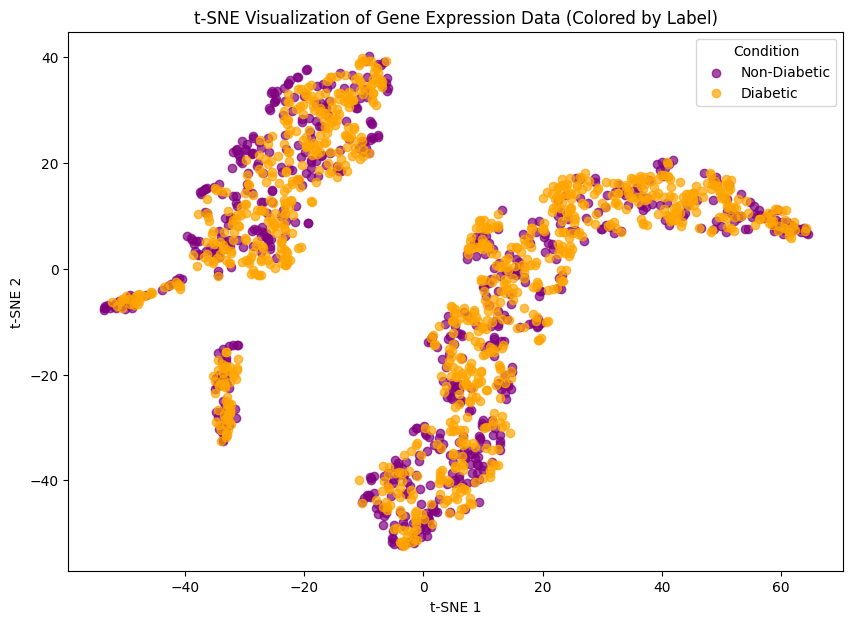

In [ ]:

df_features.columns = df_features.columns.astype(str)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(df_features)

non_diabetic = tsne_result[data['label'] == 0]
diabetic = tsne_result[data['label'] == 1]

plt.figure(figsize=(, 7))
plt.scatter(non_diabetic[:, 0], non_diabetic[:, 1], color='purple', alpha=0.7, label='Non-Diabetic')
plt.scatter(diabetic[:, 0], diabetic[:, 1], color='orange', alpha=0.7, label='Diabetic')

plt.legend(title="Condition")
plt.title('t-SNE Visualization of Gene Expression Data (Colored by Label)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, f1_score, silhouette_score
from sklearn.preprocessing import LabelEncoder

# Step 1: Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(tsne_result)

# Step 2: Compute ARI
ari = adjusted_rand_score(data['label'], cluster_labels)

# Step 3: Compute F1 Score
# Ensure binary labels (e.g., 0 and 1) for F1 calculation
le = LabelEncoder()
true_labels = le.fit_transform(data['label'])
f1 = f1_score(true_labels, cluster_labels, average='weighted')

# Step 4: Compute Silhouette Score
silhouette = silhouette_score(tsne_result, cluster_labels)

# Print results
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"F1 Score: {f1}")
print(f"Silhouette Score: {silhouette}")

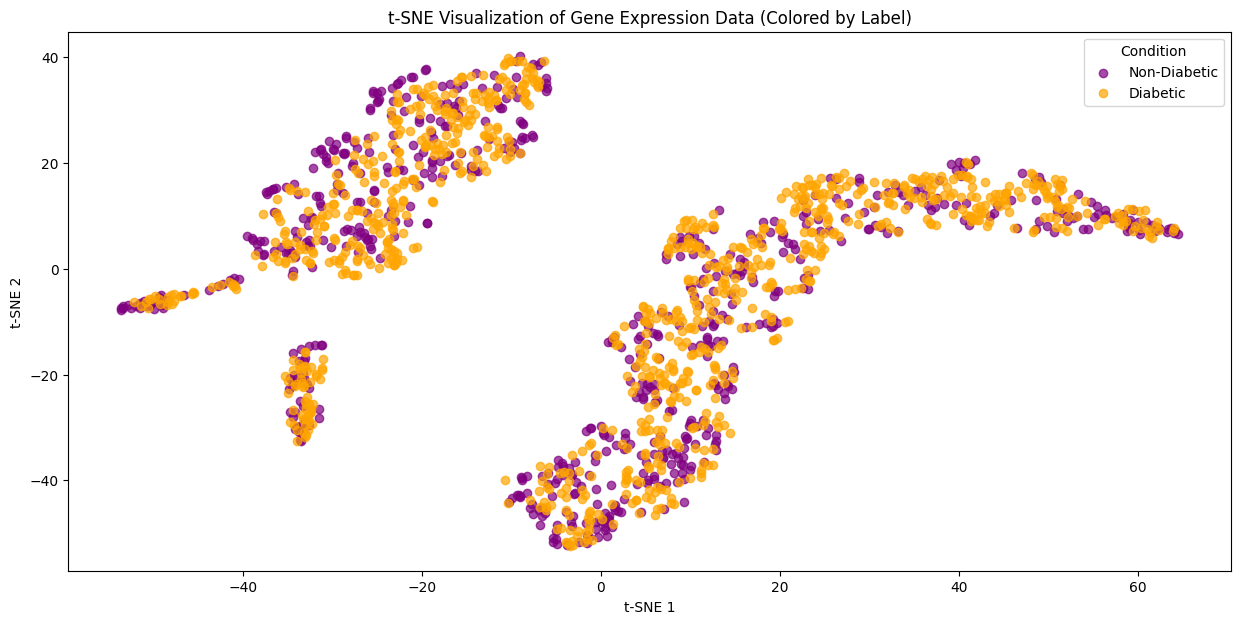

Silhouette Score (t-SNE): 0.014
Precision (t-SNE): 0.506
Recall (t-SNE): 0.472
F-score (t-SNE): 0.473


In [ ]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, precision_recall_fscore_support
import numpy as np

features = [col for col in data.columns if col not in ['label', 'Age', 'Gender', 'cell_subtype']]
df_features = data[features + ['label']]

# Ensure all column names are strings
df_features.columns = df_features.columns.astype(str)

# Perform t-SNE excluding the 'label' column
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(df_features.drop(columns=['label']))

# Separate points by labels for manual coloring
non_diabetic = tsne_result[df_features['label'] == 0]
diabetic = tsne_result[df_features['label'] == 1]

# Plot t-SNE results with manual color encoding
plt.figure(figsize=(15, 7))
plt.scatter(non_diabetic[:, 0], non_diabetic[:, 1], color='purple', alpha=0.7, label='Non-Diabetic')
plt.scatter(diabetic[:, 0], diabetic[:, 1], color='orange', alpha=0.7, label='Diabetic')

# Add legend
plt.legend(title="Condition")
plt.title('t-SNE Visualization of Gene Expression Data (Colored by Label)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# Step 1: Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(tsne_result)

# Step 2: Compute ARI
ari = adjusted_rand_score(data['label'], cluster_labels)
print(f"ARI: {ari:.3f}")

le = LabelEncoder()
true_labels = le.fit_transform(data['label'])
f1 = f1_score(true_labels, cluster_labels, average='weighted')

# Calculate and print Silhouette Score
silhouette_avg = silhouette_score(tsne_result, df_features['label'])
print(f"Silhouette Score (t-SNE): {silhouette_avg:.3f}")
print(f"Precision (t-SNE): {precision:.3f}")
print(f"Recall (t-SNE): {recall:.3f}")
print(f"F-score (t-SNE): {fscore:.3f}")

In [ ]:
# Step 2: Compute ARI
ari = adjusted_rand_score(data['label'], cluster_labels)
print(f"ARI: {ari:.3f}")


ARI: 0.001


In [ ]:
silhouette_avg = silhouette_score(tsne_result, cluster_labels)
print(f"Silhouette Score (t-SNE): {silhouette_avg:.3f}")

Silhouette Score (t-SNE): 0.475


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

numeric_data = data.select_dtypes(include=np.number)
top_5_common_genes = numeric_data.sum(axis=0).nlargest(5).index
top_5_variable_genes = numeric_data.var(axis=0).nlargest(5).index

# Step 2: Exclude top 5 common genes (ensure 'label' is also excluded if present)
df_no_common = data.drop(columns=[*top_5_common_genes, 'label'], errors='ignore')

# Exclude top 5 variable genes (ensure 'label' is also excluded if present)
df_no_variable = data.drop(columns=[*top_5_variable_genes, 'label'], errors='ignore')


# Step 3: Perform t-SNE for each case, excluding labels in both cases for computation
tsne_common = TSNE(n_components=2, perplexity=30, random_state=42)
# The 'label' column was already dropped when df_no_common was created
tsne_result_no_common = tsne_common.fit_transform(df_no_common)

tsne_variable = TSNE(n_components=2, perplexity=30, random_state=42)
# The 'label' column was already dropped when df_no_variable was created
tsne_result_no_variable = tsne_variable.fit_transform(df_no_variable)

# Step 4: Plot t-SNE results for both cases with label-based coloring

# Plot t-SNE excluding top 5 common genes
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_result_no_common[:, 0],
    y=tsne_result_no_common[:, 1],
    hue=df_no_common['label'],
    palette={0: 'purple', 1: 'orange'},
    alpha=0.7
)
plt.title('t-SNE Excluding Top 5 Common Genes (Colored by Label)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title="Condition", labels=["Non-Diabetic", "Diabetic"])
plt.show()

# Plot t-SNE excluding top 5 variable genes
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_result_no_variable[:, 0],
    y=tsne_result_no_variable[:, 1],
    hue=df_no_variable['label'],
    palette={0: 'purple', 1: 'orange'},
    alpha=0.7
)
plt.title('t-SNE Excluding Top 5 Variable Genes (Colored by Label)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title="Condition", labels=["Non-Diabetic", "Diabetic"])
plt.show()


TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [ ]:
!pip install umap-learn
import umap

In [ ]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_data)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


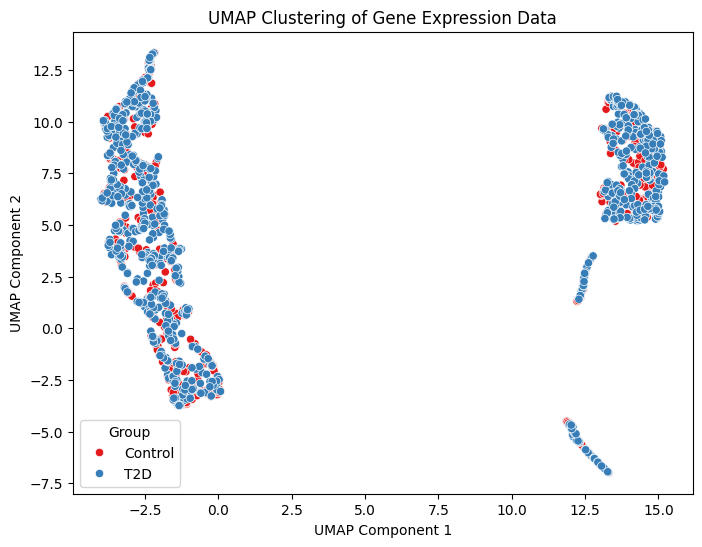

Silhouette Score (UMAP): 0.007
Adjusted Rand Index (ARI): 0.005
Precision (UMAP): 0.557
Recall (UMAP): 0.537
F-score (UMAP): 0.541


In [ ]:
# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(imputed_data)

# Create a DataFrame for UMAP results
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['group'] = data['label'].values

# Map numeric labels to string labels in a new column
umap_df['group'] = umap_df['group'].map({0: 'Control', 1: 'T2D'})

# Visualize UMAP results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df, palette='Set1')
plt.title('UMAP Clustering of Gene Expression Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Group')
plt.show()

# Calculate and print Silhouette Score
silhouette_avg = silhouette_score(umap_result, data['label'])
print(f"Silhouette Score (UMAP): {silhouette_avg:.3f}")

# Calculate and print Adjusted Rand Index (ARI)
ari = adjusted_rand_score(data['label'], umap_result.argmax(axis=1))
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

# Calculate and print F-score
precision, recall, fscore, _ = precision_recall_fscore_support(
    data['label'], umap_result.argmax(axis=1), average='weighted'
)
print(f"Precision (UMAP): {precision:.3f}")
print(f"Recall (UMAP): {recall:.3f}")
print(f"F-score (UMAP): {fscore:.3f}")


In [ ]:
import umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Ensure consistent scaling
scaler = StandardScaler()

# Apply scaling after dropping top genes
scaled_data_no_common = scaler.fit_transform(df_no_common.drop(columns='label'))
scaled_data_no_variable = scaler.fit_transform(df_no_variable.drop(columns='label'))

# UMAP for data without top 5 common genes
reducer_common = umap.UMAP(n_components=2, random_state=42)
umap_result_no_common = reducer_common.fit_transform(scaled_data_no_common)

# UMAP for data without top 5 variable genes
reducer_variable = umap.UMAP(n_components=2, random_state=42)
umap_result_no_variable = reducer_variable.fit_transform(scaled_data_no_variable)

# Prepare labels
labels_no_common = df_no_common['label'].values
labels_no_variable = df_no_variable['label'].values

# Plot UMAP excluding top 5 common genes
plt.figure(figsize=(8, 6))
plt.scatter(
    umap_result_no_common[labels_no_common == 0, 0],
    umap_result_no_common[labels_no_common == 0, 1],
    c='purple', label='Control', alpha=0.7
)
plt.scatter(
    umap_result_no_common[labels_no_common == 1, 0],
    umap_result_no_common[labels_no_common == 1, 1],
    c='orange', label='T2D', alpha=0.7
)
plt.title('UMAP Excluding Top 5 Common Genes')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

# Plot UMAP excluding top 5 variable genes
plt.figure(figsize=(8, 6))
plt.scatter(
    umap_result_no_variable[labels_no_variable == 0, 0],
    umap_result_no_variable[labels_no_variable == 0, 1],
    c='purple', label='Control', alpha=0.7
)
plt.scatter(
    umap_result_no_variable[labels_no_variable == 1, 0],
    umap_result_no_variable[labels_no_variable == 1, 1],
    c='orange', label='T2D', alpha=0.7
)
plt.title('UMAP Excluding Top 5 Variable Genes')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()



NameError: name 'df_no_common' is not defined

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-73-649f42d422db>:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='UMAP1', y='UMAP2', data=umap_df_no_common, palette='Set1')


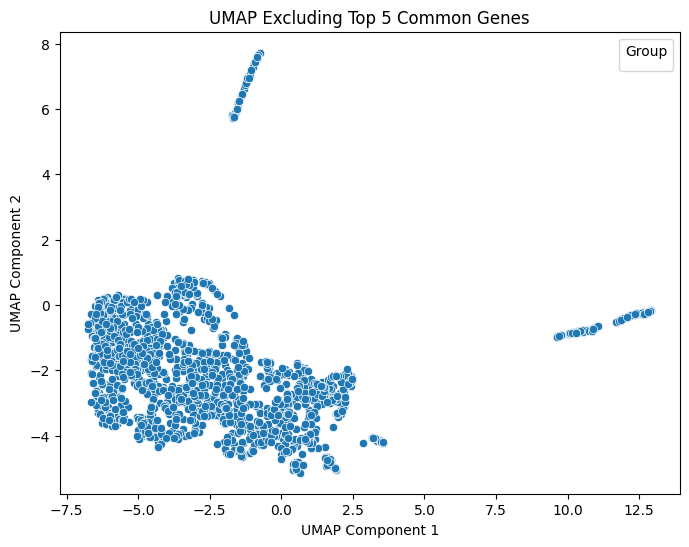

<ipython-input-73-649f42d422db>:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='UMAP1', y='UMAP2', data=umap_df_no_variable, palette='Set1')


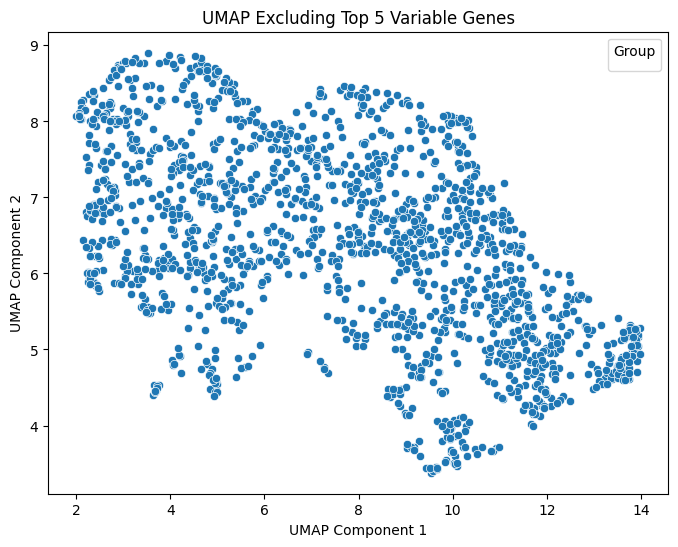

In [ ]:
import umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Identify top 5 common and variable genes
top_5_common_genes = df.sum(axis=0).nlargest(5).index
top_5_variable_genes = df.var(axis=0).nlargest(5).index

# Step 2: Exclude top 5 common genes and prepare scaled data
df_no_common = df.drop(columns=top_5_common_genes)
scaled_data_no_common = df_no_common.drop(columns='label')  # Ensure label is excluded for UMAP computation

# Exclude top 5 variable genes and prepare scaled data
df_no_variable = df.drop(columns=top_5_variable_genes)
scaled_data_no_variable = df_no_variable.drop(columns='label')  # Ensure label is excluded for UMAP computation

# Step 3: Apply UMAP

# UMAP for data without top 5 common genes
reducer_common = umap.UMAP(n_components=2, random_state=42)
umap_result_no_common = reducer_common.fit_transform(scaled_data_no_common)

# UMAP for data without top 5 variable genes
reducer_variable = umap.UMAP(n_components=2, random_state=42)
umap_result_no_variable = reducer_variable.fit_transform(scaled_data_no_variable)

# Step 4: Create DataFrames for UMAP results
umap_df_no_common = pd.DataFrame(umap_result_no_common, columns=['UMAP1', 'UMAP2'])
umap_df_no_common['group'] = df_no_common['label'].map({0: 'Control', 1: 'T2D'})

umap_df_no_variable = pd.DataFrame(umap_result_no_variable, columns=['UMAP1', 'UMAP2'])
umap_df_no_variable['group'] = df_no_variable['label'].map({0: 'Control', 1: 'T2D'})

# Step 5: Visualize UMAP results

# Plot UMAP excluding top 5 common genes
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', data=umap_df_no_common, palette='Set1')
plt.title('UMAP Excluding Top 5 Common Genes')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Group')
plt.show()

# Plot UMAP excluding top 5 variable genes
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', data=umap_df_no_variable, palette='Set1')
plt.title('UMAP Excluding Top 5 Variable Genes')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Group')
plt.show()


'label' in df_no_common.columns: True
'label' in df_no_variable.columns: True


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


NaN values in umap_df_no_common['group']: 0
NaN values in umap_df_no_variable['group']: 0


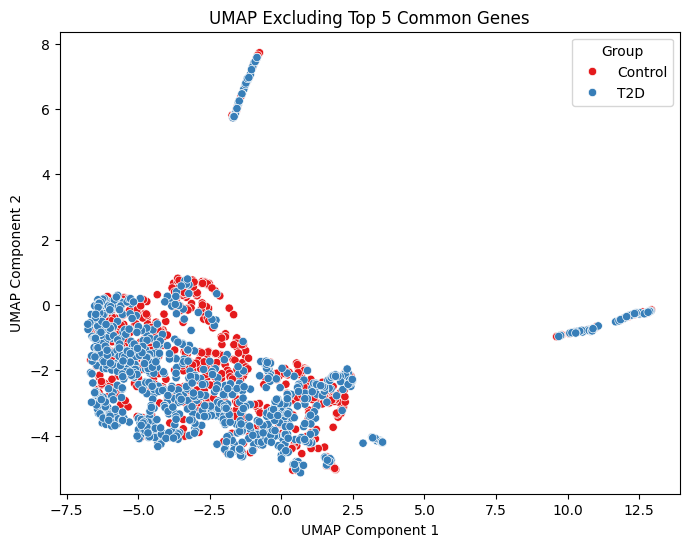

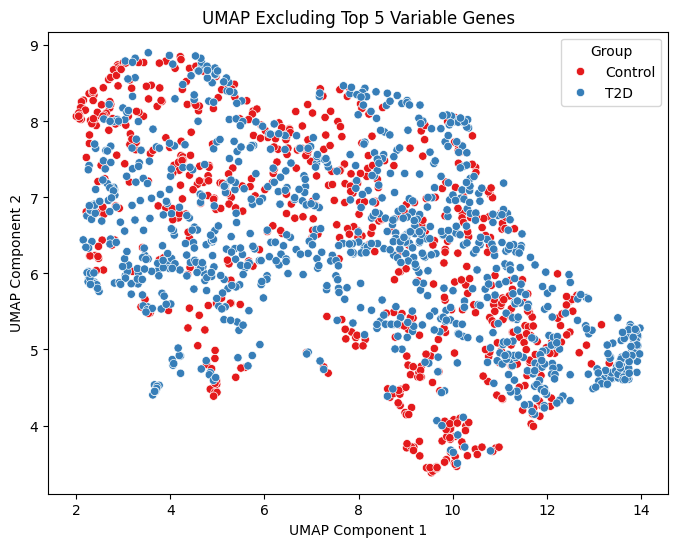

In [ ]:
import umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Identify top 5 common and variable genes, excluding 'label'
gene_columns = df.columns.drop('label')

top_5_common_genes = df[gene_columns].sum(axis=0).nlargest(5).index
top_5_variable_genes = df[gene_columns].var(axis=0).nlargest(5).index

# Step 2: Exclude top 5 common genes
df_no_common = df.drop(columns=top_5_common_genes)
print("'label' in df_no_common.columns:", 'label' in df_no_common.columns)

# Exclude top 5 variable genes
df_no_variable = df.drop(columns=top_5_variable_genes)
print("'label' in df_no_variable.columns:", 'label' in df_no_variable.columns)

# Prepare scaled data
scaled_data_no_common = df_no_common.drop(columns='label')
scaled_data_no_variable = df_no_variable.drop(columns='label')

# Step 3: Apply UMAP
reducer_common = umap.UMAP(n_components=2, random_state=42)
umap_result_no_common = reducer_common.fit_transform(scaled_data_no_common)

reducer_variable = umap.UMAP(n_components=2, random_state=42)
umap_result_no_variable = reducer_variable.fit_transform(scaled_data_no_variable)

# Step 4: Create DataFrames for UMAP results
umap_df_no_common = pd.DataFrame(umap_result_no_common, columns=['UMAP1', 'UMAP2'])
umap_df_no_variable = pd.DataFrame(umap_result_no_variable, columns=['UMAP1', 'UMAP2'])

# Reset indices
umap_df_no_common.reset_index(drop=True, inplace=True)
df_no_common.reset_index(drop=True, inplace=True)

umap_df_no_variable.reset_index(drop=True, inplace=True)
df_no_variable.reset_index(drop=True, inplace=True)

# Assign 'label' column
umap_df_no_common['label'] = df_no_common['label']
umap_df_no_variable['label'] = df_no_variable['label']

# Ensure 'label' is of correct type
umap_df_no_common['label'] = umap_df_no_common['label'].astype(int)
umap_df_no_variable['label'] = umap_df_no_variable['label'].astype(int)

# Map labels to groups
mapping_dict = {0: 'Control', 1: 'T2D'}
umap_df_no_common['group'] = umap_df_no_common['label'].map(mapping_dict)
umap_df_no_variable['group'] = umap_df_no_variable['label'].map(mapping_dict)

# Check for NaN values in 'group'
print("NaN values in umap_df_no_common['group']:", umap_df_no_common['group'].isnull().sum())
print("NaN values in umap_df_no_variable['group']:", umap_df_no_variable['group'].isnull().sum())

# Step 5: Visualize UMAP results

# Plot UMAP excluding top 5 common genes
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df_no_common, palette='Set1')
plt.title('UMAP Excluding Top 5 Common Genes')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Group')
plt.show()

# Plot UMAP excluding top 5 variable genes
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df_no_variable, palette='Set1')
plt.title('UMAP Excluding Top 5 Variable Genes')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Group')
plt.show()


In [ ]:
!pip install scvi-tools[notebooks]
import scvi

from anndata import AnnData

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.7/141.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.1/351.1 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 51.1 MB/s eta 0:00:00
  Created wheel for docrep: filena

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing CSRDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSRDataset instead.
  warn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 8.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=2f17892006d84ac5a7cf8eb376e0d6a5b18add3b2bc062515ee01dbd52ecf582
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

Number of empty cells: 0


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precis

Training:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the 

Latent representation shape: (1600, 10)


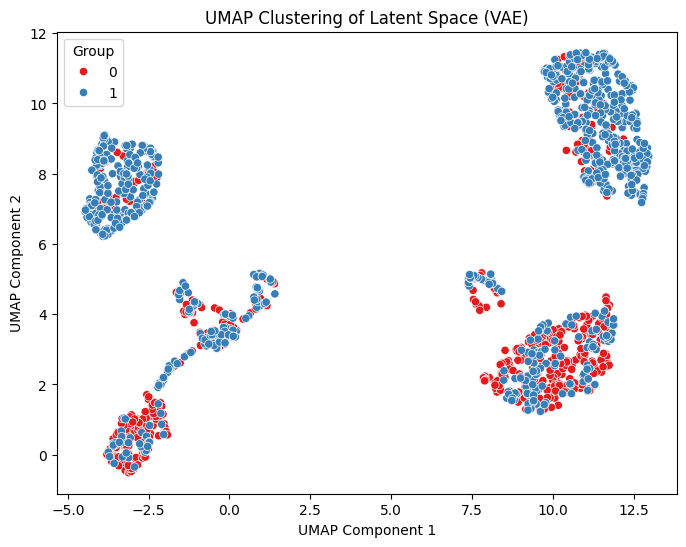

In [ ]:
import scvi
from anndata import AnnData
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
!pip install scanpy
import scanpy as sc

# Step 1: Create AnnData object, ensuring labels are included
adata = AnnData(data.drop(columns=['label']).values, obs={"label": data['label'].values})

# Step 2: Validate and filter data
# Remove cells with all-zero gene expression values (empty cells)
empty_cells = (adata.X == 0).all(axis=1)
print(f"Number of empty cells: {np.sum(empty_cells)}")
adata = adata[~empty_cells]

# Filter genes expressed in fewer than 10 cells
sc.pp.filter_genes(adata, min_cells=10)

# Convert adata.X to float32 to avoid data type issues
adata.X = adata.X.astype(np.float32)

# Step 3: Prepare the AnnData for scVI
scvi.model.SCVI.setup_anndata(adata, labels_key="label")

# Step 4: Instantiate and train a baseline VAE model
vae = scvi.model.SCVI(adata)
vae.train(max_epochs=100, train_size=0.9)

# Step 5: Get the latent representation
latent = vae.get_latent_representation()
print(f"Latent representation shape: {latent.shape}")

# Step 6: Visualize Latent Space using UMAP
# Apply UMAP on the latent space
reducer2 = umap.UMAP(n_components=2, random_state=42)
umap_result2 = reducer.fit_transform(latent)

# Convert UMAP result to DataFrame for visualization
umap_df2 = pd.DataFrame(umap_result2, columns=['UMAP1', 'UMAP2'])

filtered_labels = adata.obs['label'].values

umap_df2['group'] = filtered_labels

# Plot UMAP
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df2, palette='Set1')
plt.title('UMAP Clustering of Latent Space (VAE)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Group')
plt.show()

group              0          1
cluster                        
Cluster 1  17.472119  82.527881
Cluster 2  58.854167  41.145833
Cluster 3  17.063492  82.936508
Cluster 4  65.914221  34.085779


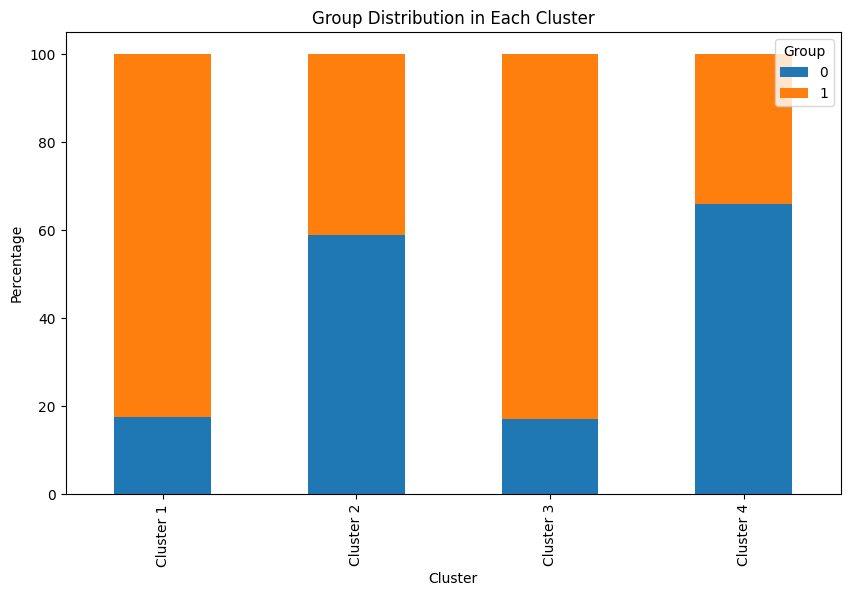

In [ ]:
# Define UMAP clusters by inspecting the plot manually or using clustering algorithms
# Here we define clusters manually based on ranges of UMAP1 and UMAP2
def assign_cluster(row):
    if row['UMAP1'] < 4 and row['UMAP2'] > 5.7:
        return 'Cluster 1'
    elif row['UMAP1'] < 4 and row['UMAP2'] < 5.7:
        return 'Cluster 2'
    elif row['UMAP1'] > 4 and row['UMAP2'] > 6:
        return 'Cluster 3'
    elif row['UMAP1'] > 4 and row['UMAP2'] <= 6:
        return 'Cluster 4'
    else:
        return 'Cluster 5'

# Apply the function to the DataFrame
umap_df2['cluster'] = umap_df2.apply(assign_cluster, axis=1)

# Calculate group percentages within each cluster
group_percentages = umap_df2.groupby('cluster')['group'].value_counts(normalize=True).mul(100).unstack().fillna(0)
print(group_percentages)

# Visualize group distributions in each cluster
group_percentages.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Group Distribution in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Group', loc='upper right')
plt.show()


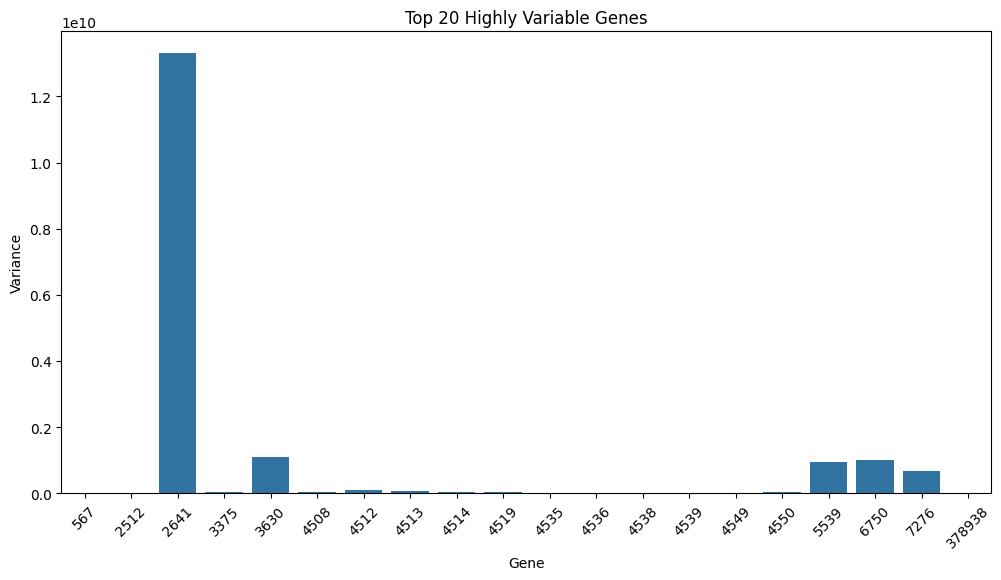

In [ ]:
#feature engineering

# Calculate variance for each gene
gene_variance = df.var(axis=0).sort_values(ascending=False)

# Plot the top 20 highly variable genes
top_genes = gene_variance.head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_genes.index, y=top_genes.values)
plt.title('Top 20 Highly Variable Genes')
plt.xlabel('Gene')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Convert expression to binary based on a threshold
threshold = 1  # Define an expression threshold
binary_features = (df > threshold).astype(int)

binary_features.head()  # Preview the binary dataset


gene.id   1          2          3          9          10         11         \
Sample_1          1          0          0          0          0          0   
Sample_2          1          0          0          0          0          0   
Sample_3          1          0          0          0          0          0   
Sample_4          0          0          0          0          0          0   
Sample_5          0          0          0          1          0          0   

gene.id   12         13         14         15         ...  101929766  \
Sample_1          0          0          1          0  ...          0   
Sample_2          1          0          0          0  ...          0   
Sample_3          0          0          1          0  ...          0   
Sample_4          0          0          0          0  ...          0   
Sample_5          0          0          1          0  ...          0   

gene.id   101929767  101929768  101929769  101929770  101929771  101930100  \
Sample_1          1          0          0          0          0          0   
Sample_2          0          0          0          0          0          0   
Sample_3          0          0          0          0          0          1   
Sample_4          0          0          0          0          0          0   
Sample_5          0          0          0          0          0          0   

gene.id   102723951  102724004  102724238  
Sample_1          0          0          0  
Sample_2          0          0          0  
Sample_3          0          0          1  
Sample_4          0          0          0  
Sample_5          0          0          0  

[5 rows x 39851 columns]

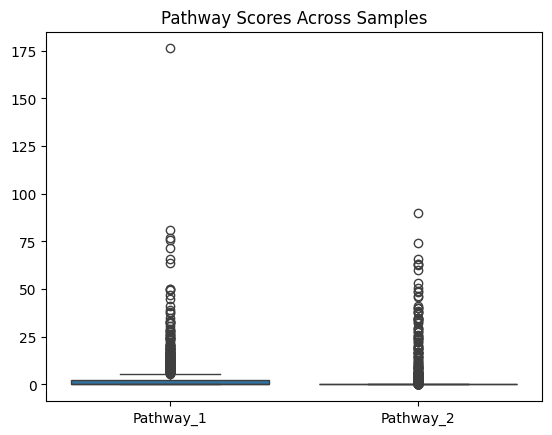

In [ ]:
# Example pathways (replace with your actual gene groups)
pathway_1_genes = [df.columns[0], df.columns[1]]  # Replace with gene names in Pathway 1
pathway_2_genes = [df.columns[2], df.columns[3]]  # Replace with gene names in Pathway 2

# Calculate pathway scores
pathway_scores = pd.DataFrame()
pathway_scores['Pathway_1'] = df[pathway_1_genes].mean(axis=1)
pathway_scores['Pathway_2'] = df[pathway_2_genes].mean(axis=1)

# Visualize pathway scores
sns.boxplot(data=pathway_scores)
plt.title('Pathway Scores Across Samples')
plt.show()


# New Section

In [ ]:
!pip install imbalanced-learn


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import umap
import torch

ModuleNotFoundError: No module named 'scanpy'

In [ ]:
# Load the dataset (replace with your actual file path)
data = pd.read_csv('/content/GSE81608_human_islets_rpkm (5).txt', sep='\t', index_col=0)

# Add a label column based on sample number
labels = [0 if i < 651 else 1 for i in range(len(data.columns))]  # 0 for control, 1 for T2D
data = data.T
data['label'] = labels  # Add label column


In [ ]:
gene_cols = [c for c in data.columns if c not in ['label']]
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Impute only on gene expression columns
imputed_gene_expression = imputer.fit_transform(data[gene_cols])
imputed_df = pd.DataFrame(imputed_gene_expression, index=data.index, columns=gene_cols)

# Update data with imputed values for gene columns
for col in gene_cols:
    data[col] = imputed_df[col]

In [ ]:
import re

metadata_file = "/content/GSE81608_series_matrix (2) 2.txt"

ages = []
genders = []
cell_subtypes = []

with open(metadata_file, 'r') as f:
    for line in f:
        line = line.strip()

        # We look only at lines that describe sample characteristics
        if line.startswith('!Sample_characteristics_ch1'):
            # Extract all values in quotes
            # Example line might look like:
            # !Sample_characteristics_ch1    "age: 23"  "age: 45" ...
            characteristics = re.findall(r'"([^"]+)"', line)

            # The first entry should tell us what kind of characteristic line this is
            # For example, if the first characteristic is "age: 23" then this is the age line.
            if characteristics:
                first_char = characteristics[0]

                # Split the first characteristic by ':'
                if ':' in first_char:
                    attr_name, _ = first_char.split(':', 1)
                    attr_name = attr_name.strip().lower()  # e.g. "age", "gender", "cell subtype"

                    # Extract just the values (e.g., from "age: 23" get "23")
                    values = []
                    for ch in characteristics:
                        # Each characteristic has the form "attr_name: value"
                        if ':' in ch:
                            _, val = ch.split(':', 1)
                            values.append(val.strip())

                    # Assign values to the appropriate list based on attr_name
                    if attr_name == 'age':
                        ages = values
                    elif attr_name == 'gender':
                        genders = values
                    elif attr_name == 'cell subtype':
                        cell_subtypes = values

# After this, you have three lists: ages, genders, and cell_subtypes
# Each list contains the values for all samples in the order they were found.
print("Ages:", ages)
print("Genders:", genders)
print("Cell Subtypes:", cell_subtypes)




In [ ]:
import pandas as pd

# Add the list as a column
data['Age'] = ages
data['Gender'] = genders
data['cell_subtype'] = cell_subtypes

NameError: name 'ages' is not defined

In [ ]:
import random

# Count number of labels
count_0 = (data['label'] == 0).sum()
count_1 = (data['label'] == 1).sum()

# Calculate the difference in number
diff = abs(count_0 - count_1)
count_del = 0

# While loop to delete random rows with label == 1
while count_del < diff:
    # Randomly choose an index
    random_index = random.choice(data.index)

    # Check label and delete if label == 1
    if data.loc[random_index, 'label'] == 1:
        data = data.drop(index=random_index)
        count_del += 1

# Check the new class distribution
print("Balanced class distribution:")
print(data['label'].value_counts())

KeyboardInterrupt: 

In [ ]:
import scanpy as sc
import anndata as ad

metadata_cols = ['label', 'Age', 'Gender', 'cell_subtype']
gene_cols = [c for c in data.columns if c not in metadata_cols]

X = data[gene_cols].values
obs = data[metadata_cols].copy()

# ... previous code ...
adata = ad.AnnData(X=X, obs=obs)
adata.var_names = [str(i) for i in gene_cols] # Convert gene_cols to string
adata.obs_names = data.index.astype(str)
# ... rest of the code ...

print("AnnData created:")
print(adata)


AnnData created:
AnnData object with n_obs × n_vars = 1600 × 39851
    obs: 'label', 'Age', 'Gender', 'cell_subtype'


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract obs dataframe
obs_data = adata.obs.copy()

# Calculate proportions for cell_subtype
cell_type_counts = obs_data['cell_subtype'].value_counts(normalize=True)
cell_type_proportions = cell_type_counts * 100  # Convert to percentages

# Calculate proportions for Gender
gender_counts = obs_data['Gender'].value_counts(normalize=True)
gender_proportions = gender_counts * 100  # Convert to percentages

# Calculate proportions for cell_subtype
group_type_counts = obs_data['label'].value_counts(normalize=True)
group_type_proportions = group_type_counts * 100  # Convert to percentages


In [ ]:
cell_type_proportions

cell_subtype
alpha    59.161290
beta     31.419355
PP        5.870968
delta     3.548387
Name: proportion, dtype: float64

In [ ]:
group_type_proportions

label
1    58.0
0    42.0
Name: proportion, dtype: float64

In [ ]:
gender_proportions

Gender
M    59.096774
F    40.903226
Name: proportion, dtype: float64

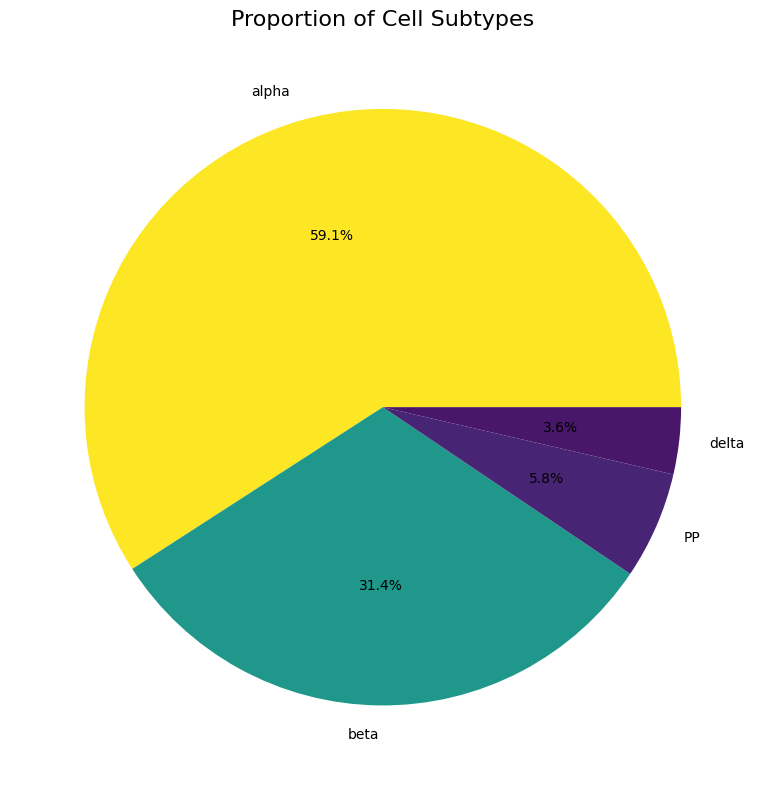

In [ ]:
import matplotlib.pyplot as plt

# Assuming cell_type_proportions is a pandas Series
plt.figure(figsize=(8, 8))  # Adjust figure size for pie chart
plt.pie(
    cell_type_proportions.values,
    labels=cell_type_proportions.index,
    autopct='%1.1f%%',
    colors=plt.cm.viridis(cell_type_proportions.values / cell_type_proportions.values.max())
)
plt.title("Proportion of Cell Subtypes", fontsize=16)
plt.tight_layout()
plt.show()

file_path = "/content/Proportion_of_Cell_Subtypes.jpeg"
plt.savefig(file_path, format="jpeg")
plt.close()


<ipython-input-212-cfc9d1b8911d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_proportions.index, y=gender_proportions.values, palette="coolwarm")


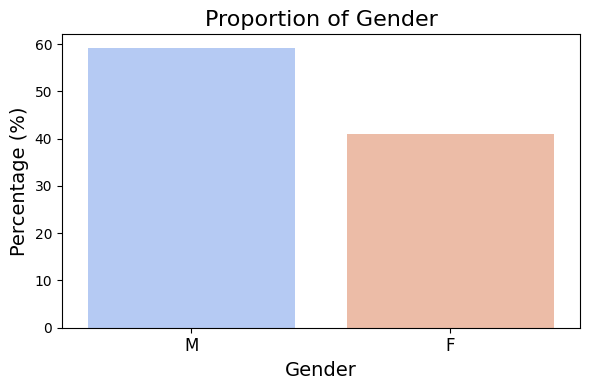

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(x=gender_proportions.index, y=gender_proportions.values, palette="coolwarm")
plt.title("Proportion of Gender", fontsize=16)
plt.xlabel("Gender", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()


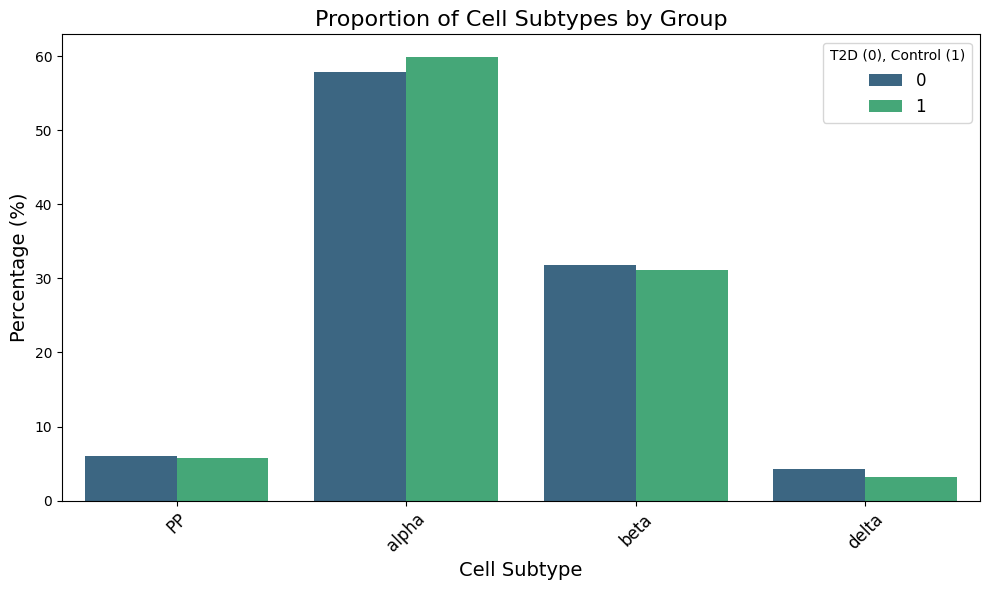

In [ ]:
# Group by Group and Cell Subtype
grouped_data = obs_data.groupby(['label', 'cell_subtype']).size().reset_index(name='count')

# Normalize within Gender
grouped_data['percentage'] = grouped_data.groupby('label')['count'].transform(lambda x: (x / x.sum()) * 100)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='cell_subtype', y='percentage', hue='label', palette="viridis")
plt.title("Proportion of Cell Subtypes by Group", fontsize=16)
plt.xlabel("Cell Subtype", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="T2D (0), Control (1)", fontsize=12)
plt.tight_layout()
plt.show()

file_path = "/content/Proportion_of_Cell_Subtypes_and_Treatments.jpeg"
plt.savefig(file_path, format="jpeg")
plt.close()



In [ ]:
empty_cells = (adata.X == 0).all(axis=1)
print(f"Number of empty cells: {np.sum(empty_cells)}")
adata = adata[~empty_cells, :]

# Filter genes: keep genes expressed in at least 15 cells
sc.pp.filter_genes(adata, min_cells=5)

# Convert adata.X to float32
adata.X = adata.X.astype(np.float32)

# Normalize total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed=False)

Number of empty cells: 0


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:284: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [ ]:
# Calculate gene variance
gene_variances = np.var(adata.X, axis=0)
# Set a variance cutoff, e.g., keep genes with variance below a certain threshold
variance_threshold = 0.2  # Adjust this based on data distribution
genes_to_keep = gene_variances < variance_threshold
adata = adata[:, genes_to_keep]


In [ ]:
adata

View of AnnData object with n_obs × n_vars = 1600 × 18355
    obs: 'label', 'Age', 'Gender', 'cell_subtype'
    var: 'n_cells'

In [ ]:
indices = range(adata.n_obs)
first_split, second_split = train_test_split(indices, test_size=0.4, random_state=42)

# Split the AnnData object
adata_one = adata[first_split].copy()
adata_two = adata[second_split].copy()

In [ ]:
adata_one

AnnData object with n_obs × n_vars = 960 × 19972
    obs: 'label', 'Age', 'Gender', 'cell_subtype', '_scvi_batch', '_scvi_labels', 'label_str', 'label_cell_subtype', 'leiden'
    var: 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'leiden'
    obsm: 'X_pca'
    obsp: 'distances', 'connectivities'

In [ ]:
adata_two

AnnData object with n_obs × n_vars = 640 × 19972
    obs: 'label', 'Age', 'Gender', 'cell_subtype', '_scvi_batch', '_scvi_labels', 'label_str', 'label_cell_subtype', 'leiden'
    var: 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'leiden'
    obsm: 'X_pca'
    obsp: 'distances', 'connectivities'

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the

Training:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the 

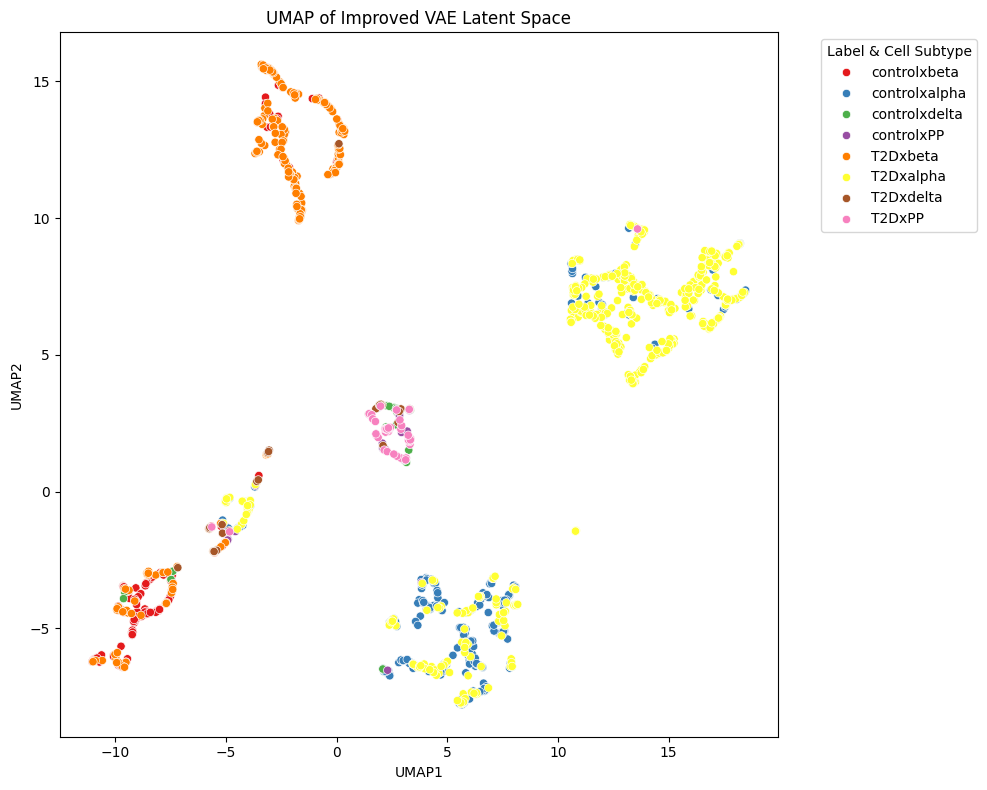

Silhouette Score (Label and Cell Subtype): 0.06694792956113815


In [ ]:

adata = adata.copy()

vae_params = {
    "n_hidden": 150,
    "n_layers": 5,
    "n_latent": 30,       # Increase latent space dimension
    "dropout_rate": 0.2,  # Add dropout for regularization
    "gene_likelihood": "zinb"  # Often used for scRNA-seq data
}

scvi.model.SCVI.setup_anndata(adata, labels_key="label")
scvi.settings.seed = 42

# Initialize SCVI model with improved parameters
vae = scvi.model.SCVI(
    adata,
    n_hidden=vae_params["n_hidden"],
    n_latent=vae_params["n_latent"],
    n_layers=vae_params["n_layers"],
    dropout_rate=vae_params["dropout_rate"],
    gene_likelihood=vae_params["gene_likelihood"]
)

# Train the model: You can also consider using early stopping
vae.train(max_epochs=500,  # Increase epochs if needed
          train_size=0.9,
          early_stopping=False,
          early_stopping_patience=100,
          early_stopping_monitor="elbo_validation")

latent = vae.get_latent_representation()

# Evaluate with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
adata.obs['label_str'] = adata.obs['label'].map({0: 'control', 1: 'T2D'})
adata.obs['label_cell_subtype'] = adata.obs['label_str'].astype(str) + 'x' + adata.obs['cell_subtype'].astype(str)
umap_df['group'] = adata.obs['label_cell_subtype'].values

plt.figure(figsize=(10,8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df, palette='Set1')
plt.title('UMAP of Improved VAE Latent Space')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Label & Cell Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
file_path = "/content/VAE_UMAP_without_Leiden_all_cells.jpeg"
plt.savefig(file_path, format="jpeg")
plt.close()


silhouette_label_cell = silhouette_score(latent, adata.obs['label_cell_subtype'])
print(f"Silhouette Score (Label and Cell Subtype): {silhouette_label_cell}")


/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the

Training:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the 

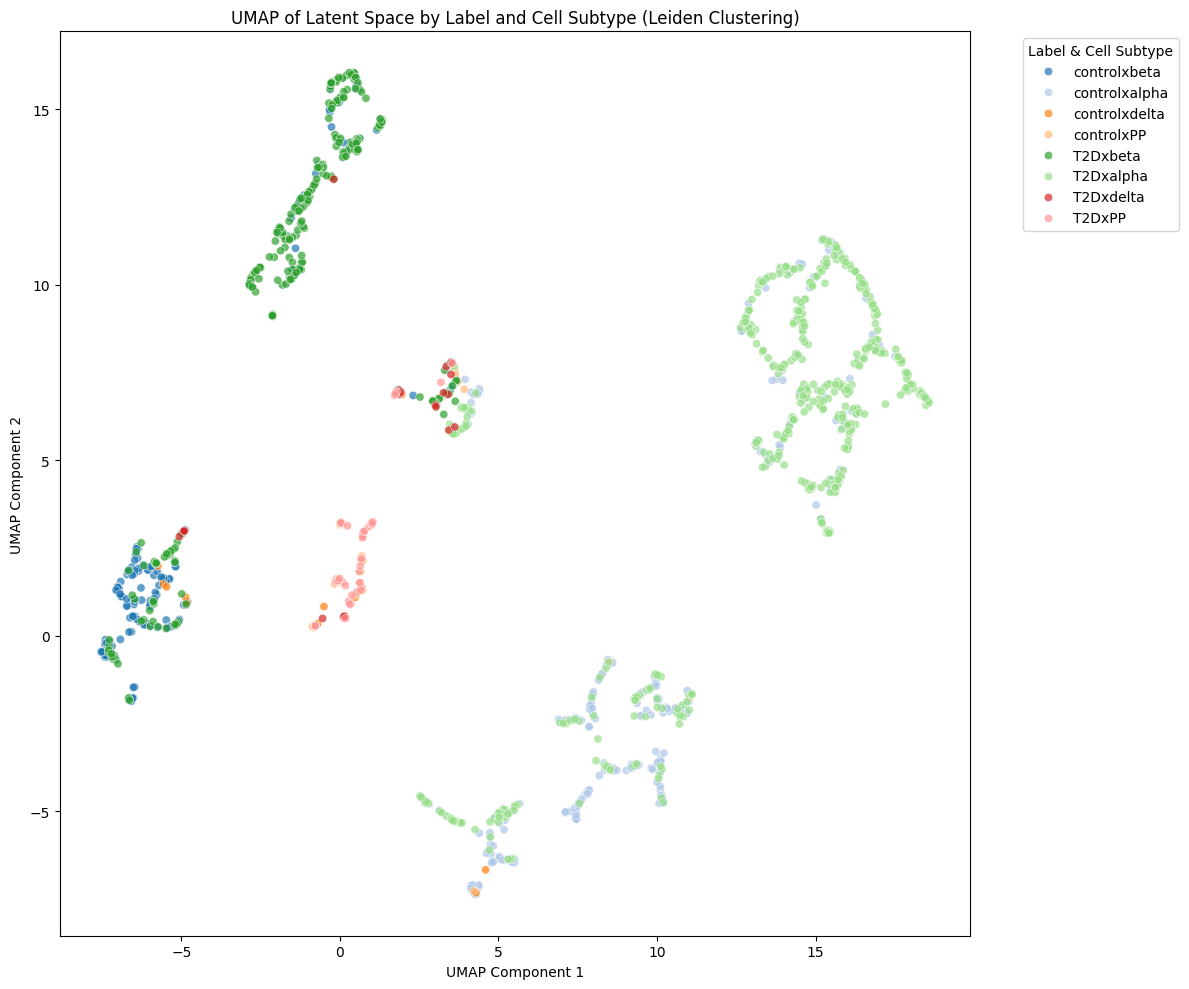

Silhouette Score (Leiden Clustering): 0.23336422443389893
Silhouette Score (Label and Cell Subtype): 0.0713866651058197
Reconstruction MSE: 859062.3084747788
Adjusted Rand Index: 0.06721718857189257
LR Accuracy: 0.7625
LR ROC-AUC: 0.7972874493927125
Classification Report LR:
               precision    recall  f1-score   support

           0       0.70      0.73      0.71       130
           1       0.81      0.78      0.80       190

    accuracy                           0.76       320
   macro avg       0.75      0.76      0.76       320
weighted avg       0.76      0.76      0.76       320

SVM Accuracy: 0.771875
SVM ROC-AUC: 0.8247773279352226
Classification Report SVM:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72       130
           1       0.80      0.82      0.81       190

    accuracy                           0.77       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.77      0.77      0.

In [ ]:
adata = adata.copy()

vae_params = {
    "n_hidden": 150,
    "n_layers": 5,
    "n_latent": 26,       # Increase latent space dimension
    "dropout_rate": 0.2,  # Add dropout for regularization
    "gene_likelihood": "zinb"  # Often used for scRNA-seq data
}

scvi.model.SCVI.setup_anndata(adata, labels_key="label")
scvi.settings.seed = 42

# Initialize SCVI model with improved parameters
vae = scvi.model.SCVI(
    adata,
    n_hidden=vae_params["n_hidden"],
    n_latent=vae_params["n_latent"],
    n_layers=vae_params["n_layers"],
    dropout_rate=vae_params["dropout_rate"],
    gene_likelihood=vae_params["gene_likelihood"]
)

# Train the model: You can also consider using early stopping
vae.train(max_epochs=500,  # Increase epochs if needed
          train_size=0.9,
          early_stopping=False,
          early_stopping_patience=100,
          early_stopping_monitor="elbo_validation")

latent = vae.get_latent_representation()

# Perform Leiden clustering
adata.obs['label_str'] = adata.obs['label'].map({0: 'control', 1: 'T2D'})
adata.obs['label_cell_subtype'] = adata.obs['label_str'].astype(str) + 'x' + adata.obs['cell_subtype'].astype(str)
adata.obsm['X_pca'] = latent  # Use the latent space for Leiden clustering
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')  # Define the graph
sc.tl.leiden(adata, resolution=1.0)  # Perform Leiden clustering
adata.obs['leiden'] = adata.obs['leiden'].astype(str)  # Convert Leiden labels to strings

# Add Leiden clusters to AnnData
adata.obs['leiden'] = adata.obs['leiden'].astype(str)
"""
# Evaluate with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
adata.obs['label_str'] = adata.obs['label'].map({0: 'control', 1: 'T2D'})
adata.obs['label_cell_subtype'] = adata.obs['label_str'].astype(str) + 'x' + adata.obs['cell_subtype'].astype(str)
umap_df['group'] = adata.obs['label_cell_subtype'].values

plt.figure(figsize=(10,8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df, palette='Set1')
plt.title('UMAP of Improved VAE Latent Space')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Label & Cell Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

"""
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)

# Create a DataFrame for UMAP results
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
# Add 'label_cell_subtype' and 'leiden' to the DataFrame
umap_df['group'] = adata.obs['label_cell_subtype'].values  # For coloring
umap_df['leiden'] = adata.obs['leiden']  # For reference, if needed

# Plot UMAP with label_cell_subtype coloring
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='group',       # Color by label_cell_subtype
    data=umap_df,
    palette='tab20',   # Use a qualitative colormap like 'tab20'
    legend='full',     # Show full legend
    alpha=0.7          # Slight transparency for better visual separation
)

# Plot Titles and Labels
plt.title('UMAP of Latent Space by Label and Cell Subtype (Leiden Clustering)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

# Adjust legend position
plt.legend(
    title='Label & Cell Subtype',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

file_path = "/content/VAE_with_all_cell_subtypes_Leiden.jpeg"
plt.savefig(file_path, format="jpeg")
plt.close()


# -------------------------------
# Step 5: Evaluate Clustering
# -------------------------------

# Compute silhouette score for Leiden clusters
silhouette_leiden = silhouette_score(latent, adata.obs['leiden'])
print(f"Silhouette Score (Leiden Clustering): {silhouette_leiden}")

# Compute silhouette score for label_cell_subtype
silhouette_label_cell = silhouette_score(latent, adata.obs['label_cell_subtype'])
print(f"Silhouette Score (Label and Cell Subtype): {silhouette_label_cell}")

# Reconstruction error (MSE)
reconstructed_data = vae.get_normalized_expression().to_numpy()
original_data = adata.X
mse = mean_squared_error(original_data.flatten(), reconstructed_data.flatten())
print(f"Reconstruction MSE: {mse}")

# Clustering metrics (ARI, NMI)
ari = adjusted_rand_score(adata.obs['cell_subtype'], latent.argmax(axis=1))
print(f"Adjusted Rand Index: {ari}")

# Classification stage (optional, no oversampling)
X = latent
y = adata.obs['label'].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Try Logistic Regression
clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
y_pred_proba_lr = clf_lr.predict_proba(X_test)[:, 1]
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"LR Accuracy: {accuracy_lr}")
print(f"LR ROC-AUC: {roc_auc_lr}")
print("Classification Report LR:\n", classification_report(y_test, y_pred_lr))

# Try SVM
svm = SVC(probability=True, random_state=42, kernel='rbf', C=1)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_pred_proba_svm = svm.predict_proba(X_test)[:, 1]
accuracy_svm = accuracy_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
print(f"SVM Accuracy: {accuracy_svm}")
print(f"SVM ROC-AUC: {roc_auc_svm}")
print("Classification Report SVM:\n", classification_report(y_test, y_pred_svm))

In [ ]:
ari = adjusted_rand_score(adata.obs['label_cell_subtype'], latent.argmax(axis=1))
print(f"Adjusted Rand Index: {ari}")

Adjusted Rand Index: 0.10578409927466922


In [ ]:
ari = adjusted_rand_score(adata.obs['label'], latent.argmax(axis=1))
print(f"Adjusted Rand Index: {ari}")

Adjusted Rand Index: 0.05354385122784982


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


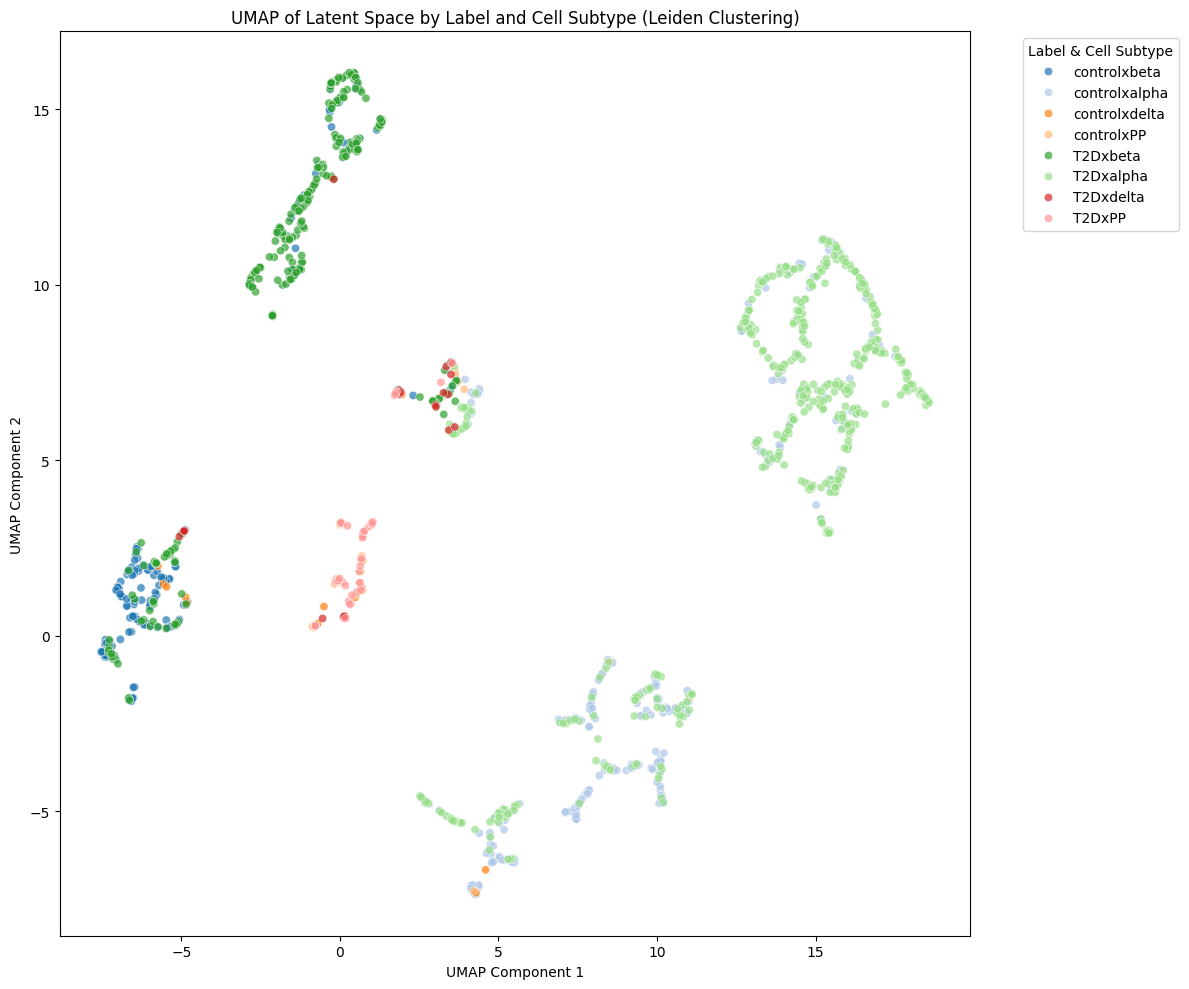

Silhouette Score (Leiden Clustering): 0.19533927738666534
Silhouette Score (Label and Cell Subtype): 0.0713866651058197
Reconstruction MSE: 859062.309493431
Adjusted Rand Index: 0.06721718857189257
LR Accuracy: 0.7625
LR ROC-AUC: 0.7972874493927125
Classification Report LR:
               precision    recall  f1-score   support

           0       0.70      0.73      0.71       130
           1       0.81      0.78      0.80       190

    accuracy                           0.76       320
   macro avg       0.75      0.76      0.76       320
weighted avg       0.76      0.76      0.76       320

SVM Accuracy: 0.771875
SVM ROC-AUC: 0.8247773279352226
Classification Report SVM:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72       130
           1       0.80      0.82      0.81       190

    accuracy                           0.77       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.77      0.77      0.7

In [ ]:

# Perform Leiden clustering
adata.obs['label_str'] = adata.obs['label'].map({0: 'control', 1: 'T2D'})
adata.obs['label_cell_subtype'] = adata.obs['label_str'].astype(str) + 'x' + adata.obs['cell_subtype'].astype(str)
adata.obsm['X_pca'] = latent  # Use the latent space for Leiden clustering
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')  # Define the graph
sc.tl.leiden(adata, resolution=0.5)  # Perform Leiden clustering
adata.obs['leiden'] = adata.obs['leiden'].astype(str)  # Convert Leiden labels to strings

# Add Leiden clusters to AnnData
adata.obs['leiden'] = adata.obs['leiden'].astype(str)
"""
# Evaluate with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
adata.obs['label_str'] = adata.obs['label'].map({0: 'control', 1: 'T2D'})
adata.obs['label_cell_subtype'] = adata.obs['label_str'].astype(str) + 'x' + adata.obs['cell_subtype'].astype(str)
umap_df['group'] = adata.obs['label_cell_subtype'].values

plt.figure(figsize=(10,8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df, palette='Set1')
plt.title('UMAP of Improved VAE Latent Space')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Label & Cell Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

"""
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)

# Create a DataFrame for UMAP results
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
# Add 'label_cell_subtype' and 'leiden' to the DataFrame
umap_df['group'] = adata.obs['label_cell_subtype'].values  # For coloring
umap_df['leiden'] = adata.obs['leiden']  # For reference, if needed

# Plot UMAP with label_cell_subtype coloring
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='group',       # Color by label_cell_subtype
    data=umap_df,
    palette='tab20',   # Use a qualitative colormap like 'tab20'
    legend='full',     # Show full legend
    alpha=0.7          # Slight transparency for better visual separation
)

# Plot Titles and Labels
plt.title('UMAP of Latent Space by Label and Cell Subtype (Leiden Clustering)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

# Adjust legend position
plt.legend(
    title='Label & Cell Subtype',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()


# -------------------------------
# Step 5: Evaluate Clustering
# -------------------------------

# Compute silhouette score for Leiden clusters
silhouette_leiden = silhouette_score(latent, adata.obs['leiden'])
print(f"Silhouette Score (Leiden Clustering): {silhouette_leiden}")

# Compute silhouette score for label_cell_subtype
silhouette_label_cell = silhouette_score(latent, adata.obs['label_cell_subtype'])
print(f"Silhouette Score (Label and Cell Subtype): {silhouette_label_cell}")

# Reconstruction error (MSE)
reconstructed_data = vae.get_normalized_expression().to_numpy()
original_data = adata.X
mse = mean_squared_error(original_data.flatten(), reconstructed_data.flatten())
print(f"Reconstruction MSE: {mse}")

# Clustering metrics (ARI, NMI)
ari = adjusted_rand_score(adata.obs['cell_subtype'], latent.argmax(axis=1))
print(f"Adjusted Rand Index: {ari}")

# Classification stage (optional, no oversampling)
X = latent
y = adata.obs['label'].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Try Logistic Regression
clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
y_pred_proba_lr = clf_lr.predict_proba(X_test)[:, 1]
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"LR Accuracy: {accuracy_lr}")
print(f"LR ROC-AUC: {roc_auc_lr}")
print("Classification Report LR:\n", classification_report(y_test, y_pred_lr))

# Try SVM
svm = SVC(probability=True, random_state=42, kernel='rbf', C=1)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_pred_proba_svm = svm.predict_proba(X_test)[:, 1]
accuracy_svm = accuracy_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
print(f"SVM Accuracy: {accuracy_svm}")
print(f"SVM ROC-AUC: {roc_auc_svm}")
print("Classification Report SVM:\n", classification_report(y_test, y_pred_svm))

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the

Training:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the 

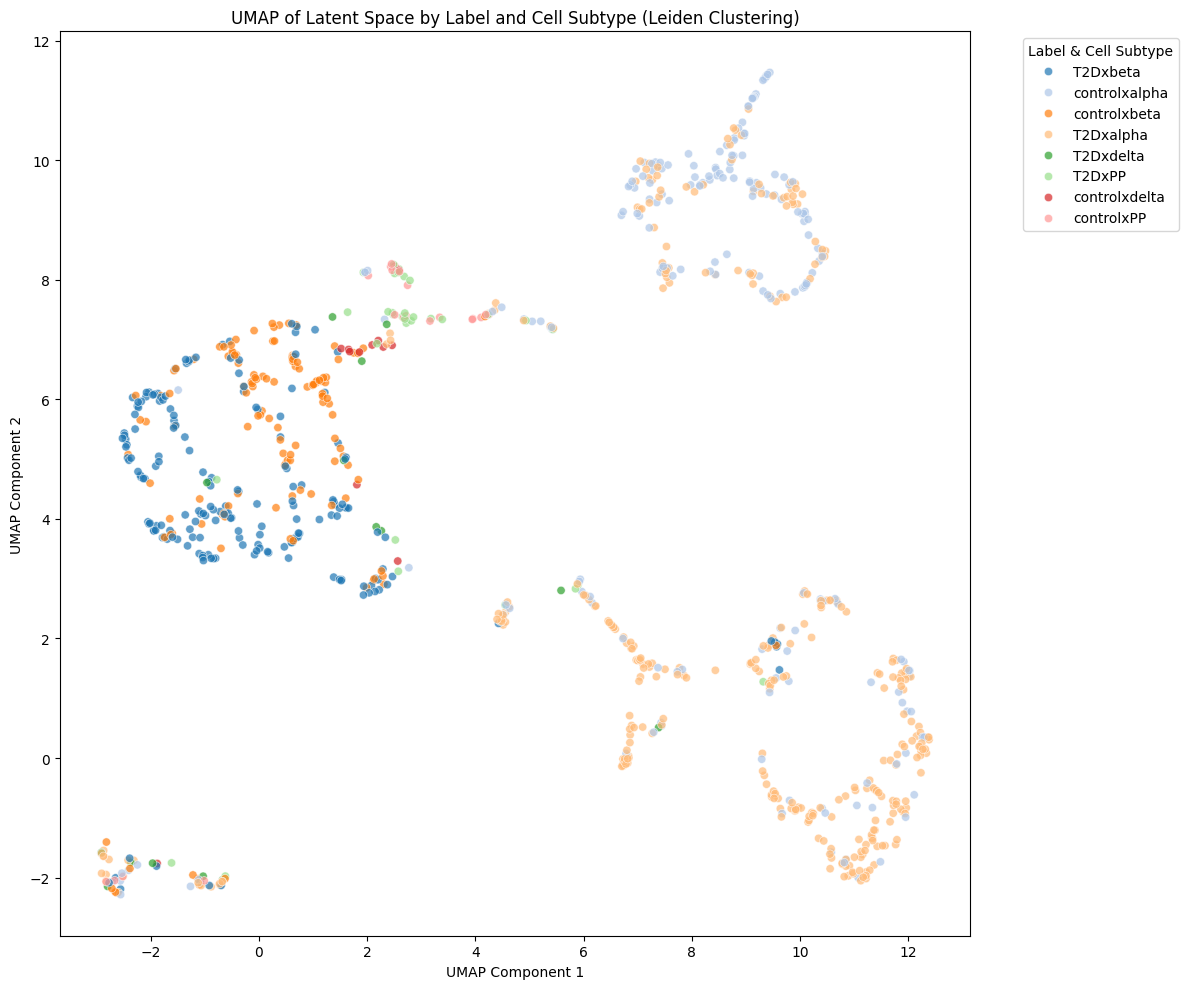

Silhouette Score (Leiden Clustering): 0.12281681597232819
Silhouette Score (Label and Cell Subtype): 0.018161697313189507


ValueError: Found input variables with inconsistent numbers of samples: [31955200, 19173120]

In [ ]:
adata_one = adata_one.copy()

vae_params = {
    "n_hidden": 150,
    "n_layers": 5,
    "n_latent": 26,       # Increase latent space dimension
    "dropout_rate": 0.2,  # Add dropout for regularization
    "gene_likelihood": "zinb"  # Often used for scRNA-seq data
}

scvi.model.SCVI.setup_anndata(adata_one, labels_key="label")
scvi.settings.seed = 42

# Initialize SCVI model with improved parameters
vae = scvi.model.SCVI(
    adata_one,
    n_hidden=vae_params["n_hidden"],
    n_latent=vae_params["n_latent"],
    n_layers=vae_params["n_layers"],
    dropout_rate=vae_params["dropout_rate"],
    gene_likelihood=vae_params["gene_likelihood"]
)

# Train the model: You can also consider using early stopping
vae.train(max_epochs=500,  # Increase epochs if needed
          train_size=0.9,
          early_stopping=False,
          early_stopping_patience=100,
          early_stopping_monitor="elbo_validation")

latent = vae.get_latent_representation()

# Perform Leiden clustering
adata_one.obs['label_str'] = adata_one.obs['label'].map({0: 'control', 1: 'T2D'})
adata_one.obs['label_cell_subtype'] = adata_one.obs['label_str'].astype(str) + 'x' + adata_one.obs['cell_subtype'].astype(str)
adata_one.obsm['X_pca'] = latent  # Use the latent space for Leiden clustering
sc.pp.neighbors(adata_one, n_neighbors=15, use_rep='X_pca')  # Define the graph
sc.tl.leiden(adata_one, resolution=1.0)  # Perform Leiden clustering
adata_one.obs['leiden'] = adata_one.obs['leiden'].astype(str)  # Convert Leiden labels to strings

# Add Leiden clusters to AnnData
adata_one.obs['leiden'] = adata_one.obs['leiden'].astype(str)

"""
# Evaluate with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
adata.obs['label_str'] = adata.obs['label'].map({0: 'control', 1: 'T2D'})
adata.obs['label_cell_subtype'] = adata.obs['label_str'].astype(str) + 'x' + adata.obs['cell_subtype'].astype(str)
umap_df['group'] = adata.obs['label_cell_subtype'].values

plt.figure(figsize=(10,8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df, palette='Set1')
plt.title('UMAP of Improved VAE Latent Space')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Label & Cell Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

"""
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)

# Create a DataFrame for UMAP results
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata_one.obs_names)
# Add 'label_cell_subtype' and 'leiden' to the DataFrame
umap_df['group'] = adata_one.obs['label_cell_subtype'].values  # For coloring
umap_df['leiden'] = adata_one.obs['leiden']  # For reference, if needed

# Plot UMAP with label_cell_subtype coloring
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='group',       # Color by label_cell_subtype
    data=umap_df,
    palette='tab20',   # Use a qualitative colormap like 'tab20'
    legend='full',     # Show full legend
    alpha=0.7          # Slight transparency for better visual separation
)

# Plot Titles and Labels
plt.title('UMAP of Latent Space by Label and Cell Subtype (Leiden Clustering)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

# Adjust legend position
plt.legend(
    title='Label & Cell Subtype',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

# -------------------------------
# Step 5: Evaluate Clustering
# -------------------------------

# Compute silhouette score for Leiden clusters
silhouette_leiden = silhouette_score(latent, adata_one.obs['leiden'])
print(f"Silhouette Score (Leiden Clustering): {silhouette_leiden}")

# Compute silhouette score for label_cell_subtype
silhouette_label_cell = silhouette_score(latent, adata_one.obs['label_cell_subtype'])
print(f"Silhouette Score (Label and Cell Subtype): {silhouette_label_cell}")

# Reconstruction error (MSE)
reconstructed_data = vae.get_normalized_expression().to_numpy()
original_data = adata.X
mse = mean_squared_error(original_data.flatten(), reconstructed_data.flatten())
print(f"Reconstruction MSE: {mse}")

ari = adjusted_rand_score(adata.obs['label'], latent.argmax(axis=1))
print(f"Adjusted Rand Index: {ari}")


/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the

Training:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the 

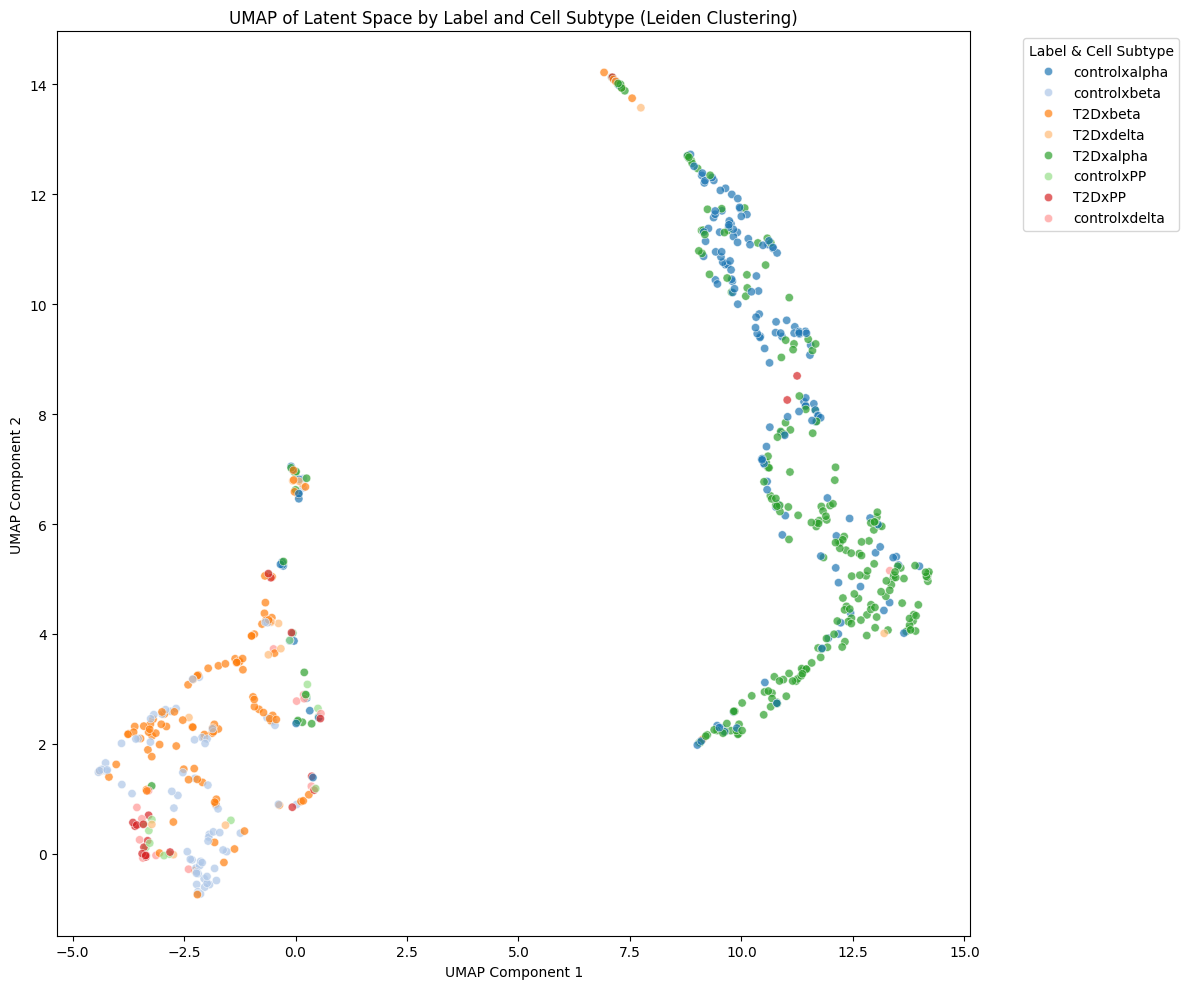

Silhouette Score (Leiden Clustering): 0.25315576791763306
Silhouette Score (Label and Cell Subtype): 0.05004803091287613
Reconstruction MSE: 0.028305737301707268


In [ ]:
adata_two = adata_two.copy()

vae_params = {
    "n_hidden": 150,
    "n_layers": 5,
    "n_latent": 26,       # Increase latent space dimension
    "dropout_rate": 0.2,  # Add dropout for regularization
    "gene_likelihood": "zinb"  # Often used for scRNA-seq data
}

scvi.model.SCVI.setup_anndata(adata_two, labels_key="label")
scvi.settings.seed = 42

# Initialize SCVI model with improved parameters
vae = scvi.model.SCVI(
    adata_two,
    n_hidden=vae_params["n_hidden"],
    n_latent=vae_params["n_latent"],
    n_layers=vae_params["n_layers"],
    dropout_rate=vae_params["dropout_rate"],
    gene_likelihood=vae_params["gene_likelihood"]
)

# Train the model: You can also consider using early stopping
vae.train(max_epochs=500,  # Increase epochs if needed
          train_size=0.9,
          early_stopping=False,
          early_stopping_patience=100,
          early_stopping_monitor="elbo_validation")

latent = vae.get_latent_representation()

# Perform Leiden clustering
adata_two.obs['label_str'] = adata_two.obs['label'].map({0: 'control', 1: 'T2D'})
adata_two.obs['label_cell_subtype'] = adata_two.obs['label_str'].astype(str) + 'x' + adata_two.obs['cell_subtype'].astype(str)
adata_two.obsm['X_pca'] = latent  # Use the latent space for Leiden clustering
sc.pp.neighbors(adata_two, n_neighbors=15, use_rep='X_pca')  # Define the graph
sc.tl.leiden(adata_two, resolution=1.0)  # Perform Leiden clustering
adata_two.obs['leiden'] = adata_two.obs['leiden'].astype(str)  # Convert Leiden labels to strings

# Add Leiden clusters to AnnData
adata_two.obs['leiden'] = adata_two.obs['leiden'].astype(str)

"""
# Evaluate with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
adata.obs['label_str'] = adata.obs['label'].map({0: 'control', 1: 'T2D'})
adata.obs['label_cell_subtype'] = adata.obs['label_str'].astype(str) + 'x' + adata.obs['cell_subtype'].astype(str)
umap_df['group'] = adata.obs['label_cell_subtype'].values

plt.figure(figsize=(10,8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df, palette='Set1')
plt.title('UMAP of Improved VAE Latent Space')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Label & Cell Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

"""
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)

# Create a DataFrame for UMAP results
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata_two.obs_names)
# Add 'label_cell_subtype' and 'leiden' to the DataFrame
umap_df['group'] = adata_two.obs['label_cell_subtype'].values  # For coloring
umap_df['leiden'] = adata_two.obs['leiden']  # For reference, if needed

# Plot UMAP with label_cell_subtype coloring
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='group',       # Color by label_cell_subtype
    data=umap_df,
    palette='tab20',   # Use a qualitative colormap like 'tab20'
    legend='full',     # Show full legend
    alpha=0.7          # Slight transparency for better visual separation
)

# Plot Titles and Labels
plt.title('UMAP of Latent Space by Label and Cell Subtype (Leiden Clustering)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

# Adjust legend position
plt.legend(
    title='Label & Cell Subtype',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

# -------------------------------
# Step 5: Evaluate Clustering
# -------------------------------

# Compute silhouette score for Leiden clusters
silhouette_leiden = silhouette_score(latent, adata_two.obs['leiden'])
print(f"Silhouette Score (Leiden Clustering): {silhouette_leiden}")

# Compute silhouette score for label_cell_subtype
silhouette_label_cell = silhouette_score(latent, adata_two.obs['label_cell_subtype'])
print(f"Silhouette Score (Label and Cell Subtype): {silhouette_label_cell}")

# Reconstruction error (MSE)
reconstructed_data = vae.get_normalized_expression().to_numpy()
original_data = adata_two.X
mse = mean_squared_error(original_data.flatten(), reconstructed_data.flatten())
print(f"Reconstruction MSE: {mse}")


In [ ]:
pip install scvi-tools[notebooks]

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.1/356.1 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.6/438.6 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 50.3 MB/s eta 0:00:00
  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl size=19877 sha256=be43151c4dbfb775e4650dff564e5c4a27af2b6e69adcc33a9761a70f2d580dc
  Stored in directory: /root/.cache/pip/wheels/c3/64/48/03c38d8d906159eaa210b3c548fdb5

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improv

Training:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the 

Latent representation shape: (1600, 10)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


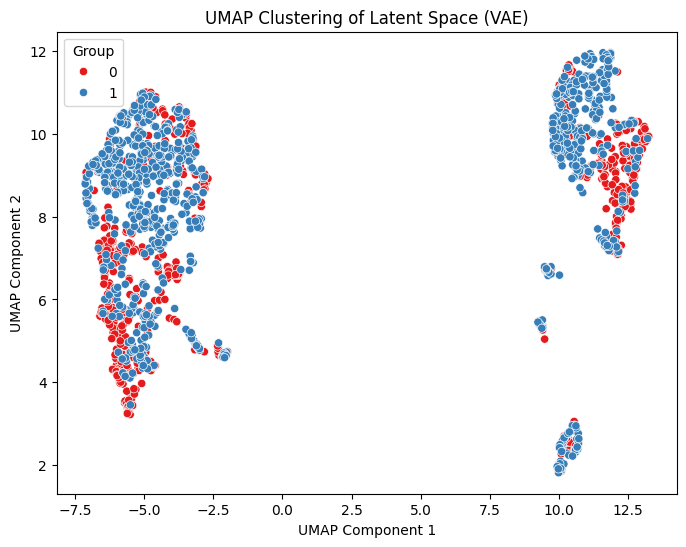

In [ ]:
import scvi
from anndata import AnnData
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
!pip install scanpy
import scanpy as sc

scvi.model.SCVI.setup_anndata(adata, labels_key="label")

# -------------------------------
# Step 7: Train SCVI Model (VAE)
# -------------------------------
vae = scvi.model.SCVI(adata)
vae.train(max_epochs=100, train_size=0.9)

# -------------------------------
# Step 8: Extract Latent Representation & UMAP
# -------------------------------
latent = vae.get_latent_representation()
print(f"Latent representation shape: {latent.shape}")


# UMAP on latent space
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
umap_df['group'] = adata.obs['label'].values

# -------------------------------
# Step 9: Plot UMAP
# -------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df, palette='Set1')
plt.title('UMAP Clustering of Latent Space (VAE)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Group')
plt.show()




/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


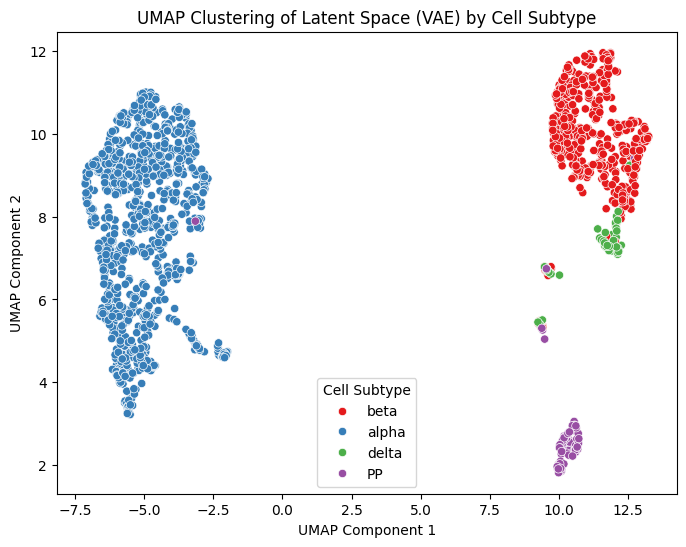

In [ ]:
# UMAP on latent space
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
umap_df['group'] = adata.obs['cell_subtype'].values  # Group by cell subtype instead of label

# -------------------------------
# Step 9: Plot UMAP
# -------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df, palette='Set1')
plt.title('UMAP Clustering of Latent Space (VAE) by Cell Subtype')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cell Subtype')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(latent, adata.obs['label'])
print(f"Silhouette Score: {silhouette_avg}")

# Get reconstructed data as NumPy array
reconstructed_data = vae.get_normalized_expression().to_numpy()
original_data = adata.X

# Flatten arrays to match shapes for MSE computation
reconstructed_data_flat = reconstructed_data.flatten()
original_data_flat = original_data.flatten()

# Compute Mean Squared Error
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(original_data_flat, reconstructed_data_flat)
print(f"Reconstruction MSE: {mse}")

from sklearn.metrics import adjusted_rand_score

# Compute ARI
ari = adjusted_rand_score(adata.obs['label'], latent.argmax(axis=1))
print(f"Adjusted Rand Index: {ari}")

Silhouette Score: 0.009826061315834522
Reconstruction MSE: 416.37518310546875
Adjusted Rand Index: 0.021986775862138284


/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improv

Training:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the 

Latent representation shape: (1600, 10)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


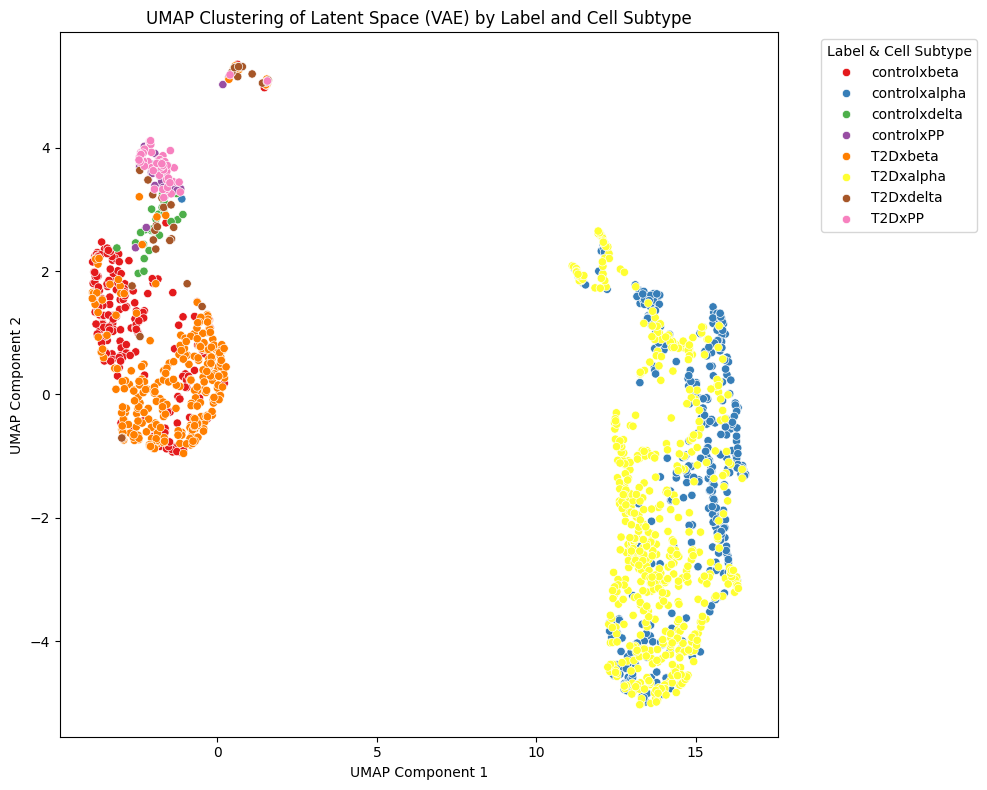

In [ ]:
import scvi
from anndata import AnnData
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
!pip install scanpy
import scanpy as sc

# Map numeric labels to strings for better readability
adata.obs['label_str'] = adata.obs['label'].map({0: 'control', 1: 'T2D'})

# Create a new combined column: "<label_str>x<cell_subtype>"
adata.obs['label_cell_subtype'] = adata.obs['label_str'].astype(str) + 'x' + adata.obs['cell_subtype'].astype(str)

# Prepare SCVI anndata
scvi.model.SCVI.setup_anndata(adata, labels_key="label")

# -------------------------------
# Step 7: Train SCVI Model (VAE)
# -------------------------------
vae = scvi.model.SCVI(adata)
vae.train(max_epochs=100, train_size=0.9)

# -------------------------------
# Step 8: Extract Latent Representation & UMAP
# -------------------------------
latent = vae.get_latent_representation()
print(f"Latent representation shape: {latent.shape}")

# UMAP on latent space
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
# Use the new combined column for grouping
umap_df['group'] = adata.obs['label_cell_subtype'].values

# -------------------------------
# Step 9: Plot UMAP
# -------------------------------
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df, palette='Set1')
plt.title('UMAP Clustering of Latent Space (VAE) by Label and Cell Subtype')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Label & Cell Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improv

Training:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the 

Latent representation shape: (1600, 10)


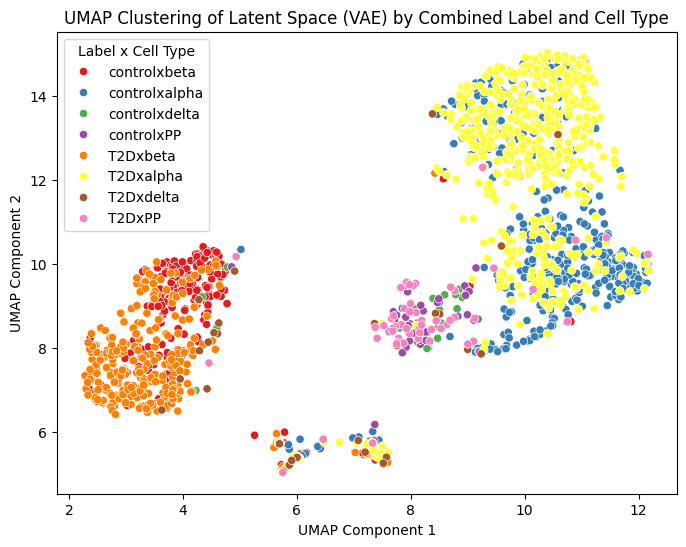

Silhouette Score: 0.023663757368922234


In [ ]:
import scvi
from anndata import AnnData
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
!pip install scanpy
import scanpy as sc

scvi.model.SCVI.setup_anndata(adata, labels_key="label")

# -------------------------------
# Step 7: Train SCVI Model (VAE)
# -------------------------------
vae = scvi.model.SCVI(adata)
vae.train(max_epochs=100, train_size=0.9)

# Map numeric labels to strings for clarity
label_map = {0: "control", 1: "T2D"}
adata.obs['label_str'] = adata.obs['label'].map(label_map)

# Create new combined column: e.g., "controlxbeta", "T2Dxalpha"
adata.obs['combined_label_subtype'] = adata.obs['label_str'] + "x" + adata.obs['cell_subtype']

# -------------------------------
# Step 8: Extract Latent Representation & UMAP
# -------------------------------
latent = vae.get_latent_representation()
print(f"Latent representation shape: {latent.shape}")

# UMAP on latent space
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent)

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
umap_df['group'] = adata.obs['combined_label_subtype'].values

# -------------------------------
# Step 9: Plot UMAP
# -------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='group', data=umap_df, palette='Set1')
plt.title('UMAP Clustering of Latent Space (VAE) by Combined Label and Cell Type')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Label x Cell Type')
plt.show()

# Calculate the silhouette score
silhouette_avg = silhouette_score(latent, adata.obs['label'])
print(f"Silhouette Score: {silhouette_avg}")



In [ ]:
# Create separate AnnData objects for each cell subtype
subtypes = adata.obs['cell_subtype'].unique()

subtype_adata = {}
for subtype in subtypes:
    # Filter for the specific cell subtype
    sub_adata = adata[adata.obs['cell_subtype'] == subtype].copy()

    # Normalize total counts per cell for the specific subset
    sc.pp.normalize_total(sub_adata, target_sum=1e4, exclude_highly_expressed=False)

    # Log-transform the data (optional, if your workflow requires it)
    #sc.pp.log1p(sub_adata)

    # Store the normalized subset
    subtype_adata[subtype] = sub_adata

# Print headers of each subtype for verification
for subtype, sub_adata in subtype_adata.items():
    print(f"\nSubtype: {subtype}")
    print(sub_adata)
